# DATA2001 Assignment 3
## Timeseries Data Analysis
### Jamie Katsamatsas s4674720
### 27/10/22

#### Dataset Columns
- Date: Date of trades
- Open: Opening price, price of first trade of the day
- High: Highest price of all trades of the day
- Low: Lowest price of all trades of the day
- Close: Closing price, price of last trade before the end of day
- Volume: Total number of stocks traded during the day
- OpenInt: Open interest, the total number of outstanding derivative contracts, such as options or futures, that have not been settled for an asset at the end of day.

# Task 1 - Data Preparation
Read the dataset using the “pandas” library and set up the index in an appropriate way for timeseries analysis. Can you identify any useful side data or exogenous variables? If so, include them into your dataframe and handle/merge them in an appropriate way. Explain how you did it along with a justification for your choices.

US interest rate is used as an exogenous variable in this assignment, the dataset can be found here https://www.investopedia.com/terms/p/percentage-change.asp

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
amazon_data = pd.read_csv("amzn.us.csv")
amazon_data

,Date,Open,High,Low,Close,Volume,OpenInt
0,1997-05-16,1.97,1.98,1.71,1.73,14700000,0
1,1997-05-19,1.76,1.77,1.62,1.71,6106800,0
2,1997-05-20,1.73,1.75,1.64,1.64,5467200,0
3,1997-05-21,1.64,1.65,1.38,1.43,18853200,0
4,1997-05-22,1.44,1.45,1.31,1.40,11776800,0
...,...,...,...,...,...,...,...
5148,2017-11-06,1109.15,1125.41,1108.77,1120.66,3331738,0
5149,2017-11-07,1124.74,1130.60,1117.50,1123.17,2684443,0
5150,2017-11-08,1122.82,1135.54,1119.11,1132.88,2576010,0
5151,2017-11-09,1125.96,1129.62,1115.77,1129.13,3729978,0


Identify if any duplicated dates exist.

In [3]:
dup_rows = amazon_data['Date'].duplicated()
dup_rows.describe()

count      5153
unique        1
top       False
freq       5153
Name: Date, dtype: object

All 'Date' values are unique.

We will now set the Date as the index and check for missing business days in the dataset.

In [4]:
amazon_data = amazon_data.set_index('Date')
amazon_data.index = amazon_data.index.astype('datetime64[ns]')

# Check if weekdays are missing from the dataset
pd.date_range(start='1997-05-16', end = '2017-11-10', freq='B').difference(amazon_data.index)

DatetimeIndex(['1997-05-26', '1997-07-04', '1997-09-01', '1997-11-27',
               '1997-12-25', '1998-01-01', '1998-01-19', '1998-02-16',
               '1998-04-10', '1998-05-25',
               ...
               '2016-09-05', '2016-11-24', '2016-12-26', '2017-01-02',
               '2017-01-16', '2017-02-20', '2017-04-14', '2017-05-29',
               '2017-07-04', '2017-09-04'],
              dtype='datetime64[ns]', length=193, freq=None)

There are 193 missing weekdays from the dataset between '1997-05-16' and '2017-11-10'. We will resample the dataset as buisness days = 'B' and fill them in by interpolating

In [5]:
# https://stackoverflow.com/questions/19324453/add-missing-dates-to-pandas-dataframe
amazon_data = amazon_data.resample('B').mean()
amazon_data = amazon_data.interpolate()
amazon_data

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
1997-05-16,1.97,1.98,1.71,1.73,14700000.0,0.0
1997-05-19,1.76,1.77,1.62,1.71,6106800.0,0.0
1997-05-20,1.73,1.75,1.64,1.64,5467200.0,0.0
1997-05-21,1.64,1.65,1.38,1.43,18853200.0,0.0
1997-05-22,1.44,1.45,1.31,1.40,11776800.0,0.0
...,...,...,...,...,...,...
2017-11-06,1109.15,1125.41,1108.77,1120.66,3331738.0,0.0
2017-11-07,1124.74,1130.60,1117.50,1123.17,2684443.0,0.0
2017-11-08,1122.82,1135.54,1119.11,1132.88,2576010.0,0.0


In [6]:
# Rename "Date" to "Datetime"
# amazon_data.rename(columns = {'Date': 'Datetime'}, inplace=True)


# set index to datetime
dates = pd.date_range(start='1997-05-16', end = '2017-11-10', freq='B')
amazon_data.set_index(dates, inplace=True)

# cast "Date" to "Datetime"
amazon_data.index = amazon_data.index.astype('datetime64[ns]')

In [7]:
amazon_data.head()

,Open,High,Low,Close,Volume,OpenInt
1997-05-16,1.97,1.98,1.71,1.73,14700000.0,0.0
1997-05-19,1.76,1.77,1.62,1.71,6106800.0,0.0
1997-05-20,1.73,1.75,1.64,1.64,5467200.0,0.0
1997-05-21,1.64,1.65,1.38,1.43,18853200.0,0.0
1997-05-22,1.44,1.45,1.31,1.40,11776800.0,0.0


### % Change Data
In stock trading Change and % Change are commonly tracked variables to see the relative change of the stock day to day. This value can be easily calculated once you know the stock close and open prices. Therefore I have decided to generate the change and % change values for this dataset

##### Reference

https://www.investopedia.com/terms/p/percentage-change.asp

In [8]:
amazon_data["Change"] = amazon_data["Close"] - amazon_data["Open"]
amazon_data["%Change"] = amazon_data["Change"] / amazon_data["Open"]
amazon_data

,Open,High,Low,Close,Volume,OpenInt,Change,%Change
1997-05-16,1.97,1.98,1.71,1.73,14700000.0,0.0,-0.24,-0.121827
1997-05-19,1.76,1.77,1.62,1.71,6106800.0,0.0,-0.05,-0.028409
1997-05-20,1.73,1.75,1.64,1.64,5467200.0,0.0,-0.09,-0.052023
1997-05-21,1.64,1.65,1.38,1.43,18853200.0,0.0,-0.21,-0.128049
1997-05-22,1.44,1.45,1.31,1.40,11776800.0,0.0,-0.04,-0.027778
...,...,...,...,...,...,...,...,...
2017-11-06,1109.15,1125.41,1108.77,1120.66,3331738.0,0.0,11.51,0.010377
2017-11-07,1124.74,1130.60,1117.50,1123.17,2684443.0,0.0,-1.57,-0.001396
2017-11-08,1122.82,1135.54,1119.11,1132.88,2576010.0,0.0,10.06,0.008960
2017-11-09,1125.96,1129.62,1115.77,1129.13,3729978.0,0.0,3.17,0.002815


Now the data contains a date that has a frequency of buisness days.

### Exogeneous Variable US Interest Rate
The exogenous variable for this dataset will be the US interest rate also known as the Federal Funds Rate. The interest rate has been included as it can affect stock prices with higher interest rates negatively affecting stock prices and vice versa. The dataset can be found here https://fred.stlouisfed.org/series/FEDFUNDS

#### Reference

https://www.investopedia.com/investing/how-interest-rates-affect-stock-market/#:~:text=Higher%20interest%20rates%20tend%20to,future%20cash%20flow%20is%20higher.

In [9]:
# Import Federal Funds Rate (Exogenous Variable)
interest_rate = pd.read_csv("FEDFUNDS.csv")
interest_rate

,DATE,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
815,2022-06-01,1.21
816,2022-07-01,1.68
817,2022-08-01,2.33
818,2022-09-01,2.56


The interest rate dataset has a frequency of monthly, we want it to be in business daily recordings. So we must set the index to be the date then resample the dataset to a freuquency of 'B' which is for buisness days.

In [10]:
# https://stackoverflow.com/questions/66759539/change-monthly-data-to-daily-in-pandas

# Set index as date
interest_rate.rename(columns = {'DATE': 'Date', 'FEDFUNDS': 'Interest Rate'}, inplace=True)

# Set index to datetime
interest_rate = interest_rate.set_index(['Date'])

# Cast index to datetime
interest_rate.index = interest_rate.index.astype('datetime64[ns]')

# Resample dates
interest_rate = interest_rate.resample('B').ffill()

interest_rate.head()

,Interest Rate
Date,
1954-07-01,0.8
1954-07-02,0.8
1954-07-05,0.8
1954-07-06,0.8
1954-07-07,0.8


Now that both the Amazon stock price and interest rate data are set to a frequency of buisness days we can simply join the datasets together.

In [11]:
# Join amazn stock and interest rate
amazon_data = amazon_data.join(interest_rate)
amazon_data

,Open,High,Low,Close,Volume,OpenInt,Change,%Change,Interest Rate
1997-05-16,1.97,1.98,1.71,1.73,14700000.0,0.0,-0.24,-0.121827,5.50
1997-05-19,1.76,1.77,1.62,1.71,6106800.0,0.0,-0.05,-0.028409,5.50
1997-05-20,1.73,1.75,1.64,1.64,5467200.0,0.0,-0.09,-0.052023,5.50
1997-05-21,1.64,1.65,1.38,1.43,18853200.0,0.0,-0.21,-0.128049,5.50
1997-05-22,1.44,1.45,1.31,1.40,11776800.0,0.0,-0.04,-0.027778,5.50
...,...,...,...,...,...,...,...,...,...
2017-11-06,1109.15,1125.41,1108.77,1120.66,3331738.0,0.0,11.51,0.010377,1.16
2017-11-07,1124.74,1130.60,1117.50,1123.17,2684443.0,0.0,-1.57,-0.001396,1.16
2017-11-08,1122.82,1135.54,1119.11,1132.88,2576010.0,0.0,10.06,0.008960,1.16
2017-11-09,1125.96,1129.62,1115.77,1129.13,3729978.0,0.0,3.17,0.002815,1.16


# Task 2 - Exploratory Data Analysis
Visualise the entire data set, and comment on the patterns you can observe with respect to the features discussed in the lectures. Include visualisations appropriate for uncertainty and correlation where appropriate.

In [12]:
amazon_data['year'] = amazon_data.index.year
amazon_data['month'] = amazon_data.index.month_name()
amazon_data['day of month'] = amazon_data.index.to_period('B').day
amazon_data['day'] = amazon_data.index.day_name()
amazon_data

,Open,High,Low,Close,Volume,OpenInt,Change,%Change,Interest Rate,year,month,day of month,day
1997-05-16,1.97,1.98,1.71,1.73,14700000.0,0.0,-0.24,-0.121827,5.50,1997,May,16,Friday
1997-05-19,1.76,1.77,1.62,1.71,6106800.0,0.0,-0.05,-0.028409,5.50,1997,May,19,Monday
1997-05-20,1.73,1.75,1.64,1.64,5467200.0,0.0,-0.09,-0.052023,5.50,1997,May,20,Tuesday
1997-05-21,1.64,1.65,1.38,1.43,18853200.0,0.0,-0.21,-0.128049,5.50,1997,May,21,Wednesday
1997-05-22,1.44,1.45,1.31,1.40,11776800.0,0.0,-0.04,-0.027778,5.50,1997,May,22,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-06,1109.15,1125.41,1108.77,1120.66,3331738.0,0.0,11.51,0.010377,1.16,2017,November,6,Monday
2017-11-07,1124.74,1130.60,1117.50,1123.17,2684443.0,0.0,-1.57,-0.001396,1.16,2017,November,7,Tuesday
2017-11-08,1122.82,1135.54,1119.11,1132.88,2576010.0,0.0,10.06,0.008960,1.16,2017,November,8,Wednesday
2017-11-09,1125.96,1129.62,1115.77,1129.13,3729978.0,0.0,3.17,0.002815,1.16,2017,November,9,Thursday


Dataset starts with Friday, will need to add a Friday recording to the tiling later on.

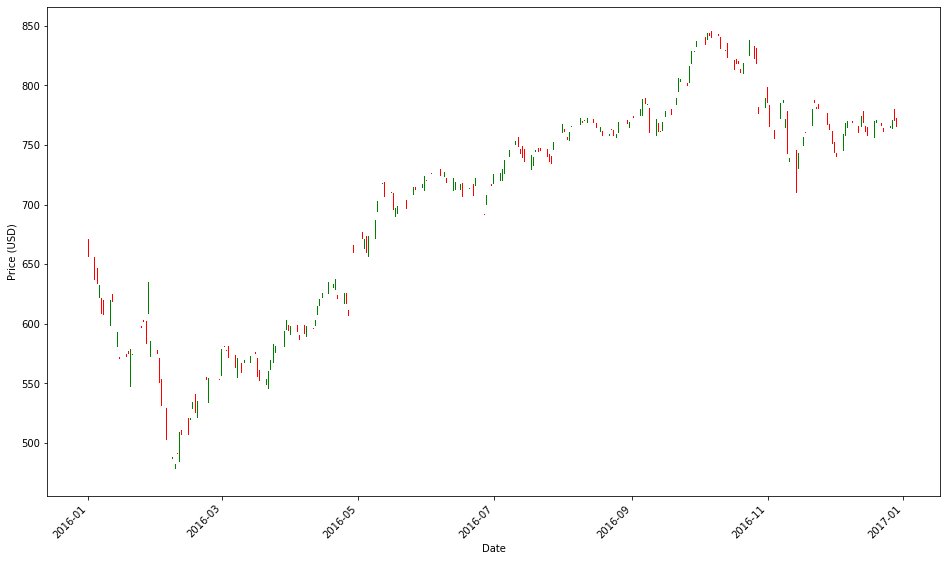

In [13]:
# https://www.statology.org/matplotlib-python-candlestick-chart/

time_period_start = "2016-01-01"
time_period_end = "2017-01-01"

amazon_data_chunk = amazon_data[time_period_start:time_period_end]

plt.figure(figsize=(16,9))

width = 0.4
width2 = 0.05

up = amazon_data_chunk[amazon_data_chunk['Close'] >= amazon_data_chunk['Open']]
down = amazon_data_chunk[amazon_data_chunk['Close'] < amazon_data_chunk['Open']]

# plt.plot(down.index, down["Close"], color='yellow')

# plot up prices
plt.bar(up.index, up["Close"] - up["Open"], width, bottom=up["Open"], color='green')
plt.bar(up.index, up["High"] - up["Close"], width2, bottom=up["Close"], color='green')
plt.bar(up.index, up["Low"] - up["Open"], width2, bottom=up["Open"], color='green')

# plot down prices
plt.bar(down.index, down["Close"] - down["Open"], width, bottom=down["Open"], color='red')
plt.bar(down.index, down['High'] - down["Open"], width2, bottom=down["Open"], color='red')
plt.bar(down.index, down["Low"] - down["Close"], width2, bottom=down["Close"], color='red')

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')

plt.xlabel('Date')
plt.ylabel('Price (USD)')

#display candlestick chart
plt.show()

Candle Stick plots are commonly used to show stock high, low, open and close prices. A year period has been shown as it is easier to read than when the entire dataset is shown.

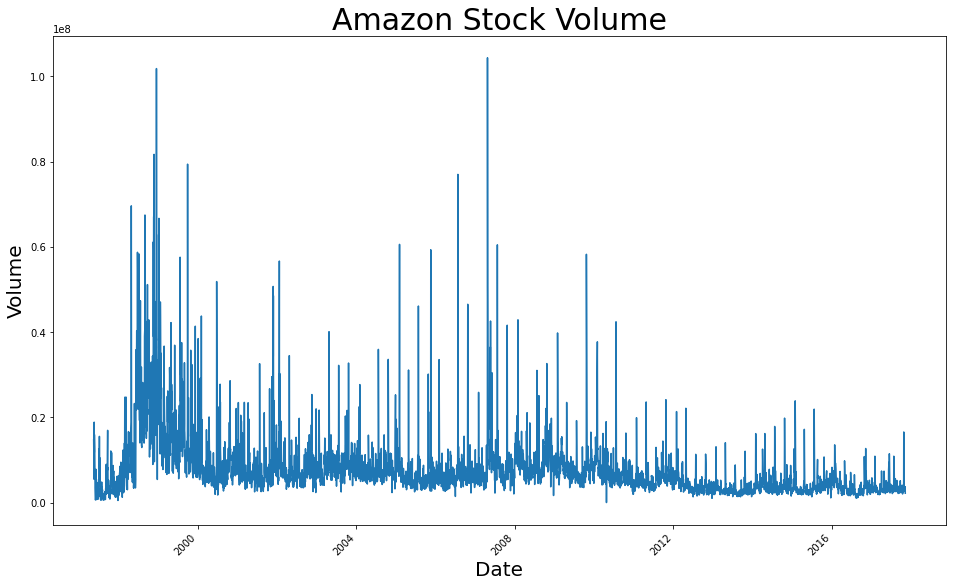

In [14]:
# plot Volume
plt.figure(figsize=(16,9))

plt.plot(amazon_data.index, amazon_data["Volume"])

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')

plt.title('Amazon Stock Volume', fontsize=30)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Volume', fontsize=20)

#display candlestick chart
plt.show()

Amazon Stock volume overall appears to have a large increase at the beginning around 1999 but then the overall trend appears to be faily flat from 2000 onwards.

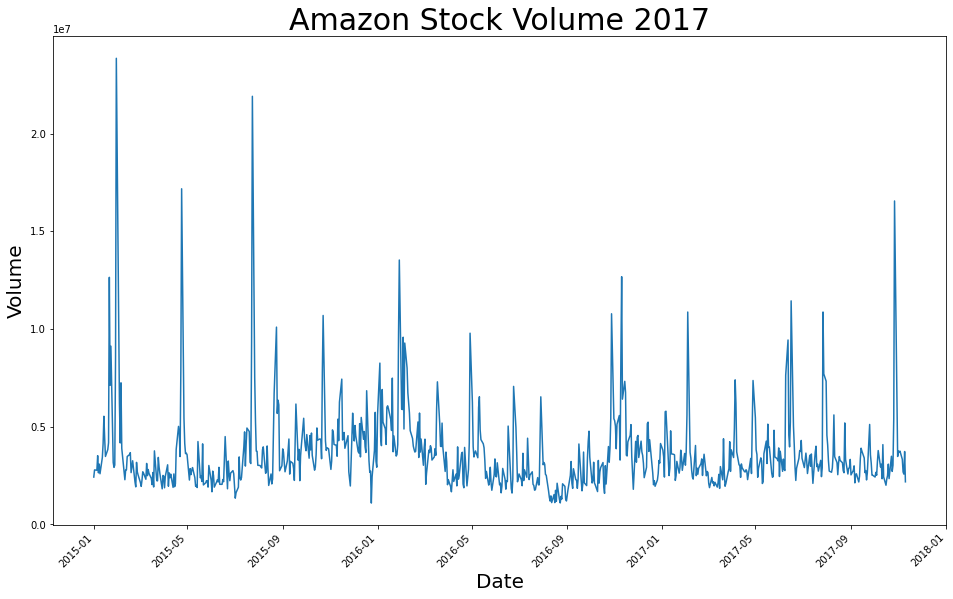

In [15]:
# plot Volume
plt.figure(figsize=(16,9))

plt.plot(amazon_data["2015":"2017"].index, amazon_data["2015":"2017"]["Volume"])

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')

plt.title('Amazon Stock Volume 2017', fontsize=30)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Volume', fontsize=20)

#display candlestick chart
plt.show()

The stock volume for the last 2 years of the dataset appear to have a relatively flat trend that appears to have a slight bump around the start of 2016

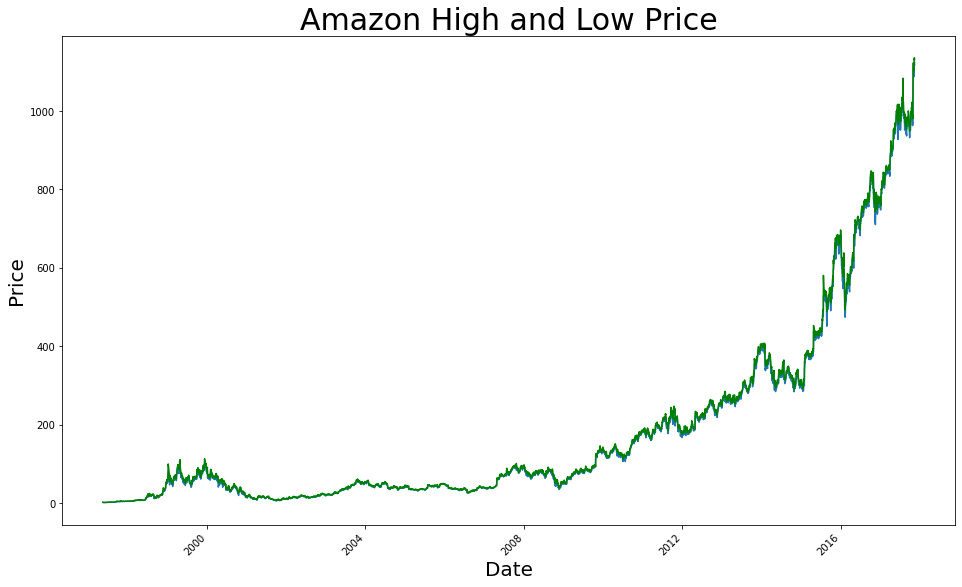

In [16]:
# plot Low, High
plt.figure(figsize=(16,9))

plt.plot(amazon_data.index, amazon_data["Low"])
plt.plot(amazon_data.index, amazon_data["High"], 'green')

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')

plt.title('Amazon High and Low Price', fontsize=30)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Price', fontsize=20)

#display candlestick chart
plt.show()

From the above plot you can see that the plots for the 'Low' and 'High' daily prices are very similar as the green line is overlapping the blue line used for the 'Low'. Since 'Open' and 'Close' are also within the range of 'High' 'Low' therefore we will only plot 'High'. The amazon price is shown to have an exponential growth.

#### Plot High and Low for year 2017

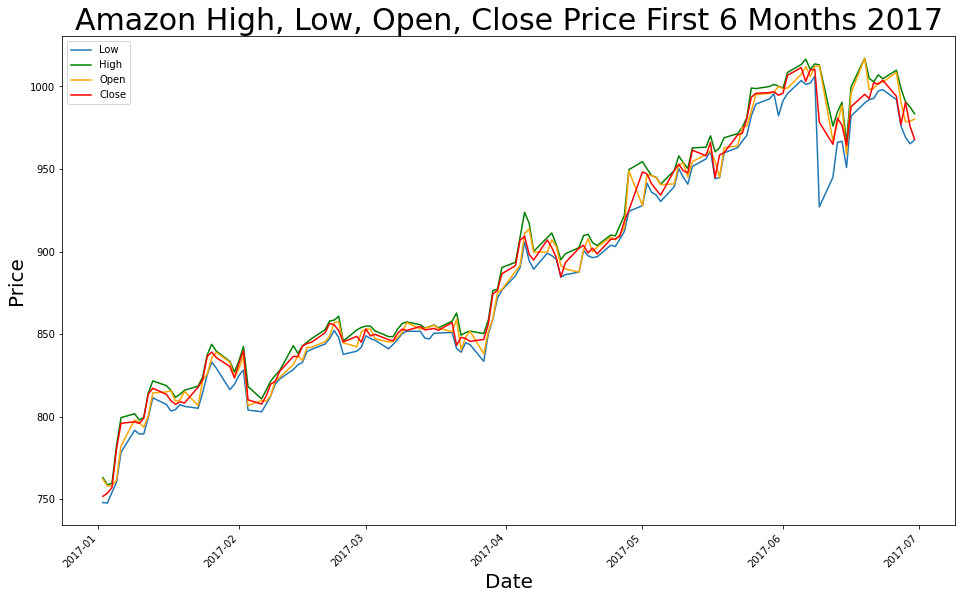

In [17]:
# plot Low, High
plt.figure(figsize=(16,9))

plt.plot(amazon_data["2017-01":"2017-06"].index, amazon_data["2017-01":"2017-06"]["Low"], label='Low')
plt.plot(amazon_data["2017-01":"2017-06"].index, amazon_data["2017-01":"2017-06"]["High"], 'green', label='High')
plt.plot(amazon_data["2017-01":"2017-06"].index, amazon_data["2017-01":"2017-06"]["Open"], 'orange', label='Open')
plt.plot(amazon_data["2017-01":"2017-06"].index, amazon_data["2017-01":"2017-06"]["Close"], 'red', label='Close')

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')

plt.title('Amazon High, Low, Open, Close Price First 6 Months 2017', fontsize=30)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Price', fontsize=20)

plt.legend()

#display candlestick chart
plt.show()

The above plot reiterates the statement above that the Low, High, Open, Close values all appear to follow the same trend and seasonality.

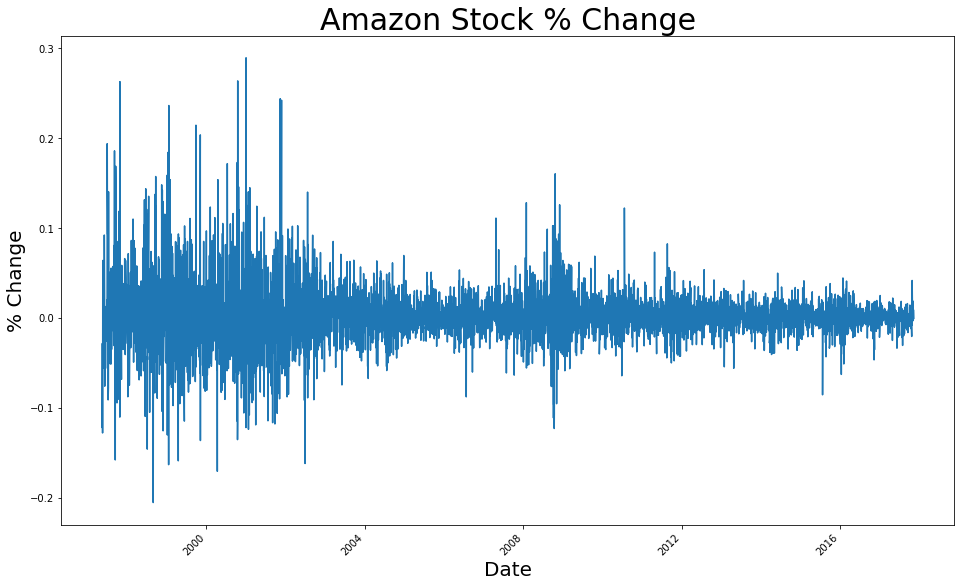

In [18]:
# plot %change
plt.figure(figsize=(16,9))

plt.plot(amazon_data.index, amazon_data["%Change"])

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')

plt.title('Amazon Stock % Change', fontsize=30)
plt.xlabel('Date', fontsize=20)
plt.ylabel('% Change', fontsize=20)

#display candlestick chart
plt.show()

Amazons stock % change values appear to be very large in the first few years 1999-2002, after this point the % change reduces.

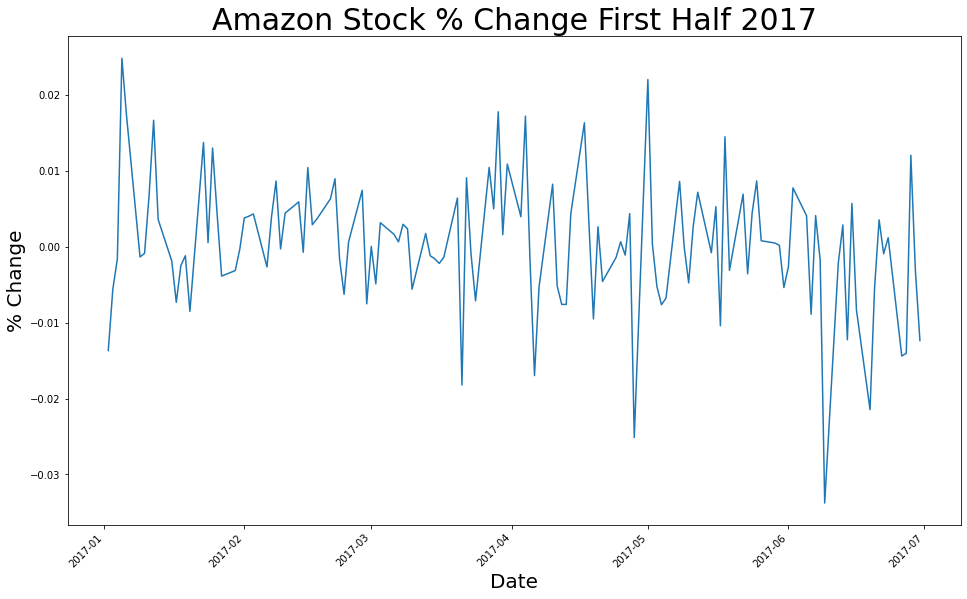

In [19]:
# plot %change
plt.figure(figsize=(16,9))

plt.plot(amazon_data["2017-01":"2017-06"].index, amazon_data["2017-01":"2017-06"]["%Change"])

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')

plt.title('Amazon Stock % Change First Half 2017', fontsize=30)
plt.xlabel('Date', fontsize=20)
plt.ylabel('% Change', fontsize=20)

#display candlestick chart
plt.show()

The two plots above show that the % Change generally hovers around 0.

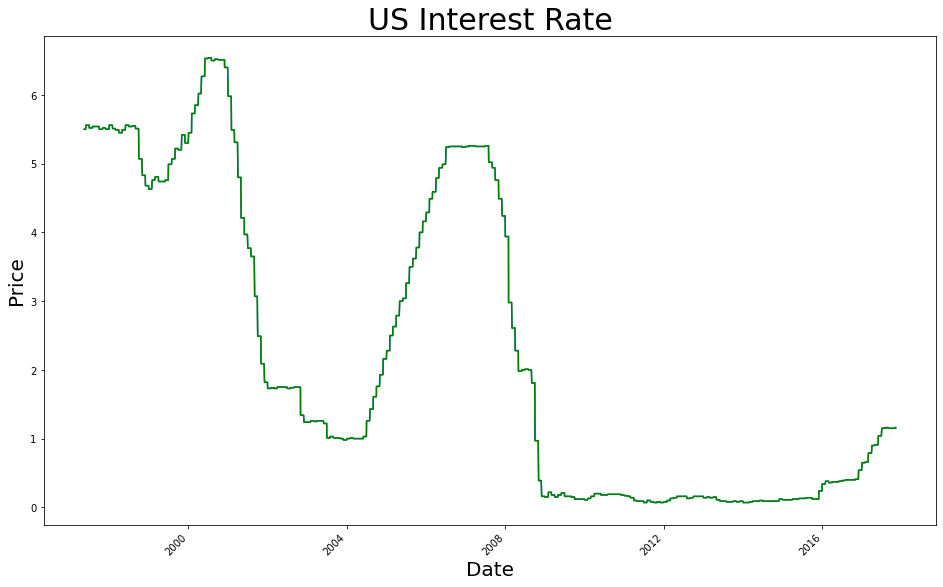

In [20]:
# plot Low, High
plt.figure(figsize=(16,9))

plt.plot(amazon_data.index, amazon_data["Interest Rate"])
plt.plot(amazon_data.index, amazon_data["Interest Rate"], 'green')

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')

plt.title('US Interest Rate', fontsize=30)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Price', fontsize=20)

#display candlestick chart
plt.show()

The us interest rate is shown above, the interest rate is shown to dip between 2000 and 2002, then there is a large spike from 2005 to 2009, after this point the interest rate flattens out until 2016.

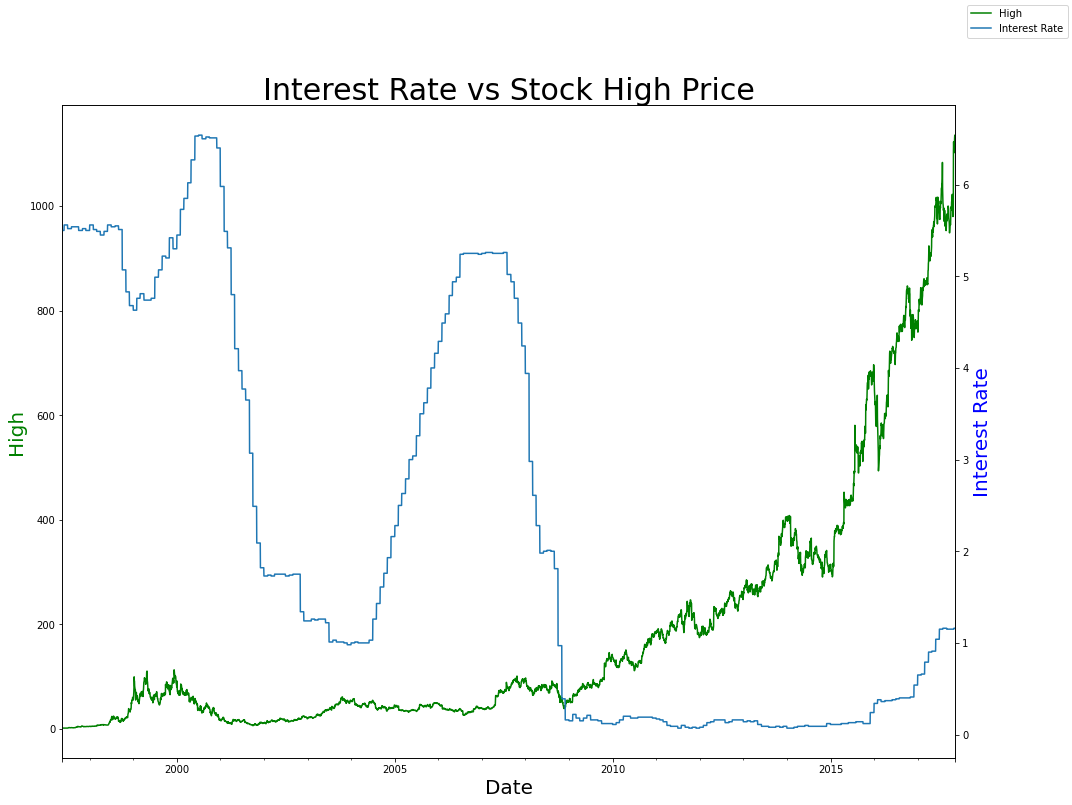

In [21]:
# https://stackoverflow.com/questions/14762181/adding-a-y-axis-label-to-secondary-y-axis-in-matplotlib
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
amazon_data['High'].plot(ax=ax1, color='green', label='High')
amazon_data['Interest Rate'].plot(ax=ax2, label='Interest Rate')

plt.title("Interest Rate vs Stock High Price", fontsize=30)

ax1.set_xlabel('Date', fontsize=20)
ax2.set_ylabel('Interest Rate', color='b', fontsize=20)
ax1.set_ylabel('High', color='g', fontsize=20)

fig.legend()

fig.set_size_inches((16,12))

plt.show()

Plotting the stock price against the US interest rate shows an interesting sharp increase in price trend in 2009 at the same time the US interest rate had a large drop. Before 2009 the Amazon stock price appears to have a faily flat trend, after 2009 the trend increases exponentially. The interest rate appears to have a large fall in 2009 from 5.2% to 0.2% then the Interest Rate trend is very horizontal.

This plot appears to show that a low interest rate is good for stock price.

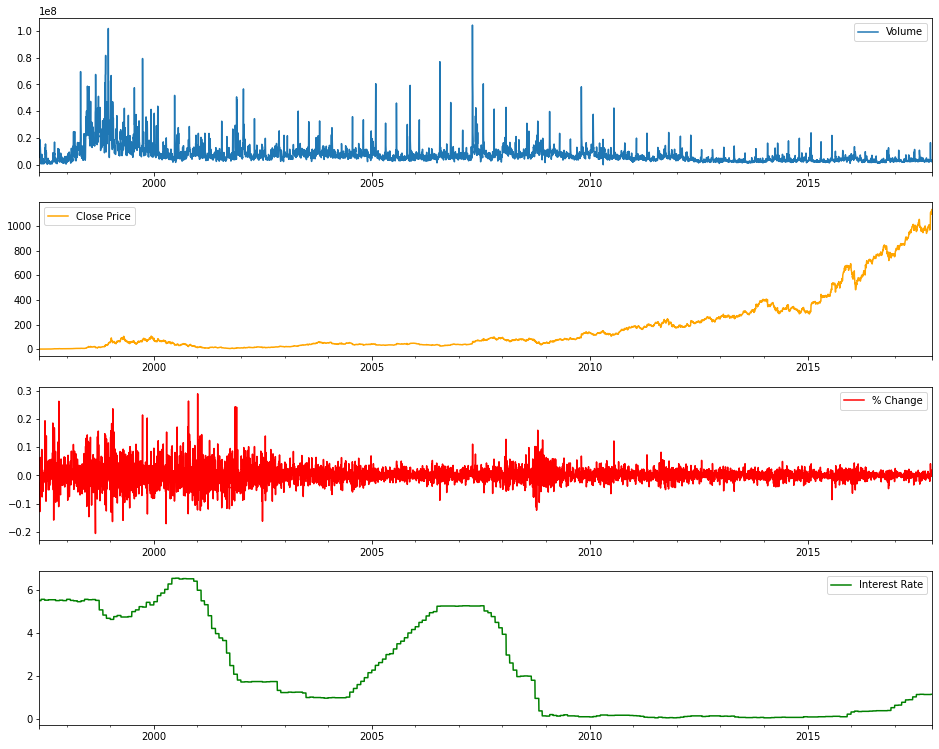

In [22]:
# Plot volume
fig, ax = plt.subplots(4)
amazon_data["Volume"].plot(label='Volume', ax=ax[0])
ax[0].legend(['Volume'])
amazon_data["Close"].plot(color='orange', label='Close', ax=ax[1])
ax[1].legend(['Close Price'])
amazon_data["%Change"].plot(color='red', label='%Change', ax=ax[2])
ax[2].legend(['% Change'])
amazon_data["Interest Rate"].plot(color='green', label='Interest Rate', ax=ax[3])
ax[3].legend(['Interest Rate'])
fig.set_size_inches((16, 13))
plt.legend()
plt.show()

With all plots shown above one another you can see a large spike in % change around 2009 at the same time the interest rate drops and the Close Price increases sharply.

### Line Plots

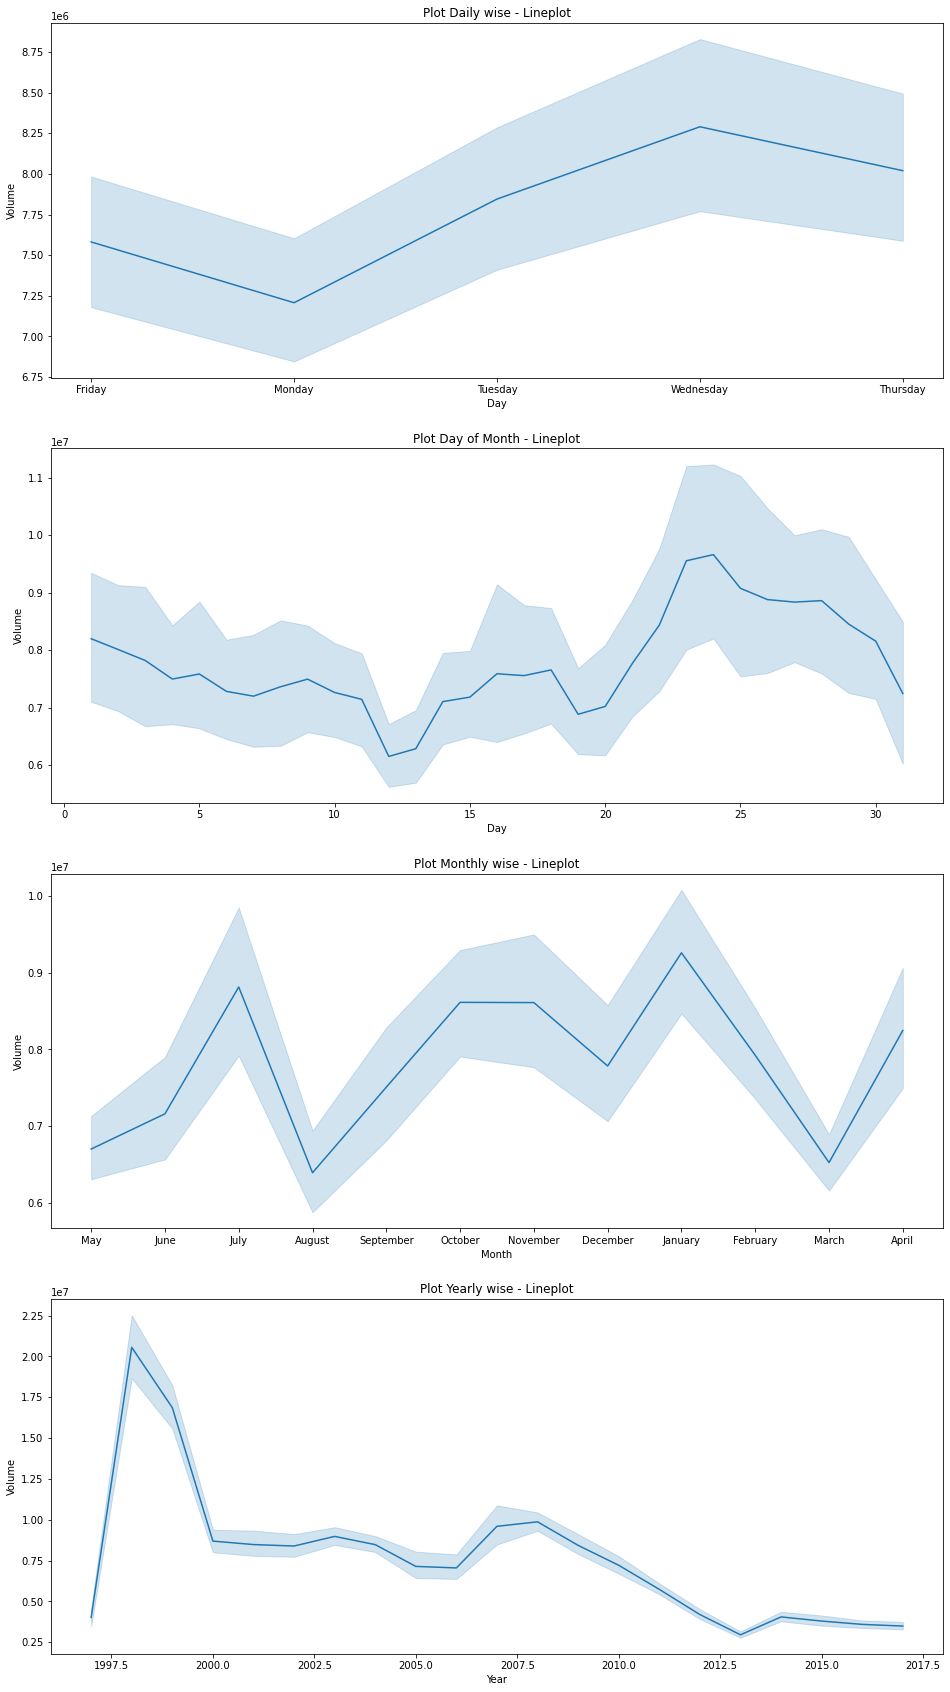

In [23]:
fig, axes = plt.subplots(4)

# fig, axes = plt.subplots(1,1,squeeze=False)
# fig.set_size_inches(16,4)
sns.lineplot(data=amazon_data, x='day', y=amazon_data['Volume'], ax=axes[0])
axes[0].set_title("Plot Daily wise - Lineplot")
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Volume')

# fig, axes = plt.subplots(1,1,squeeze=False)
# fig.set_size_inches(16,4)
sns.lineplot(data=amazon_data, x='day of month', y=amazon_data['Volume'], ax=axes[1])
axes[1].set_title("Plot Day of Month - Lineplot")
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Volume')

# lineplot from  seaborn package shows the trend-line along with the confidence intervals (i.e. variation of data at each time point)
# fig, axes = plt.subplots(1,1,squeeze=False)
# fig.set_size_inches(16,4)
sns.lineplot(data=amazon_data, x='month', y=amazon_data['Volume'], ax=axes[2])
axes[2].set_title("Plot Monthly wise - Lineplot")
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Volume')

# lineplot from  seaborn package shows the trend-line along with the confidence intervals (i.e. variation of data at each time point)
# fig, axes = plt.subplots(1,1,squeeze=False)
# fig.set_size_inches(16,4)
sns.lineplot(data=amazon_data, x='year', y=amazon_data['Volume'], ax=axes[3])
axes[3].set_title("Plot Yearly wise - Lineplot")
axes[3].set_xlabel('Year')
axes[3].set_ylabel('Volume')


fig.set_size_inches(16,30)

From the Lineplots above We can see a clear seasonal component for the first plot which is Daily plot (days of the week). The daily plot shows a Volume high on Wendesday and a Volume low on Monday.

The second plot shows the Volume for each day over a month, this plot shows the Volume trending downwards for the first half of the month with the minimum around the 13th day, then the Volume trends upwards with a maximum around the 24th day. Since this plot shows the distribution of values over the entire month for every month in the dataset you could consider this to also show a seasonal component as each month recording follows similar shape to what is shown in this plot.

These results of the Daily and Day of the month plots show that depending on what granularity you look at the data at, you could investigate seasonality for the weeks or for the months.

The third plot shows the Volume over a year and the last plot shows the Volume over the years.

The Yearly plot shows a clear decrease in Volume over the years, as the data trend appears almost flat at the end of the dataset.

### Box Plots

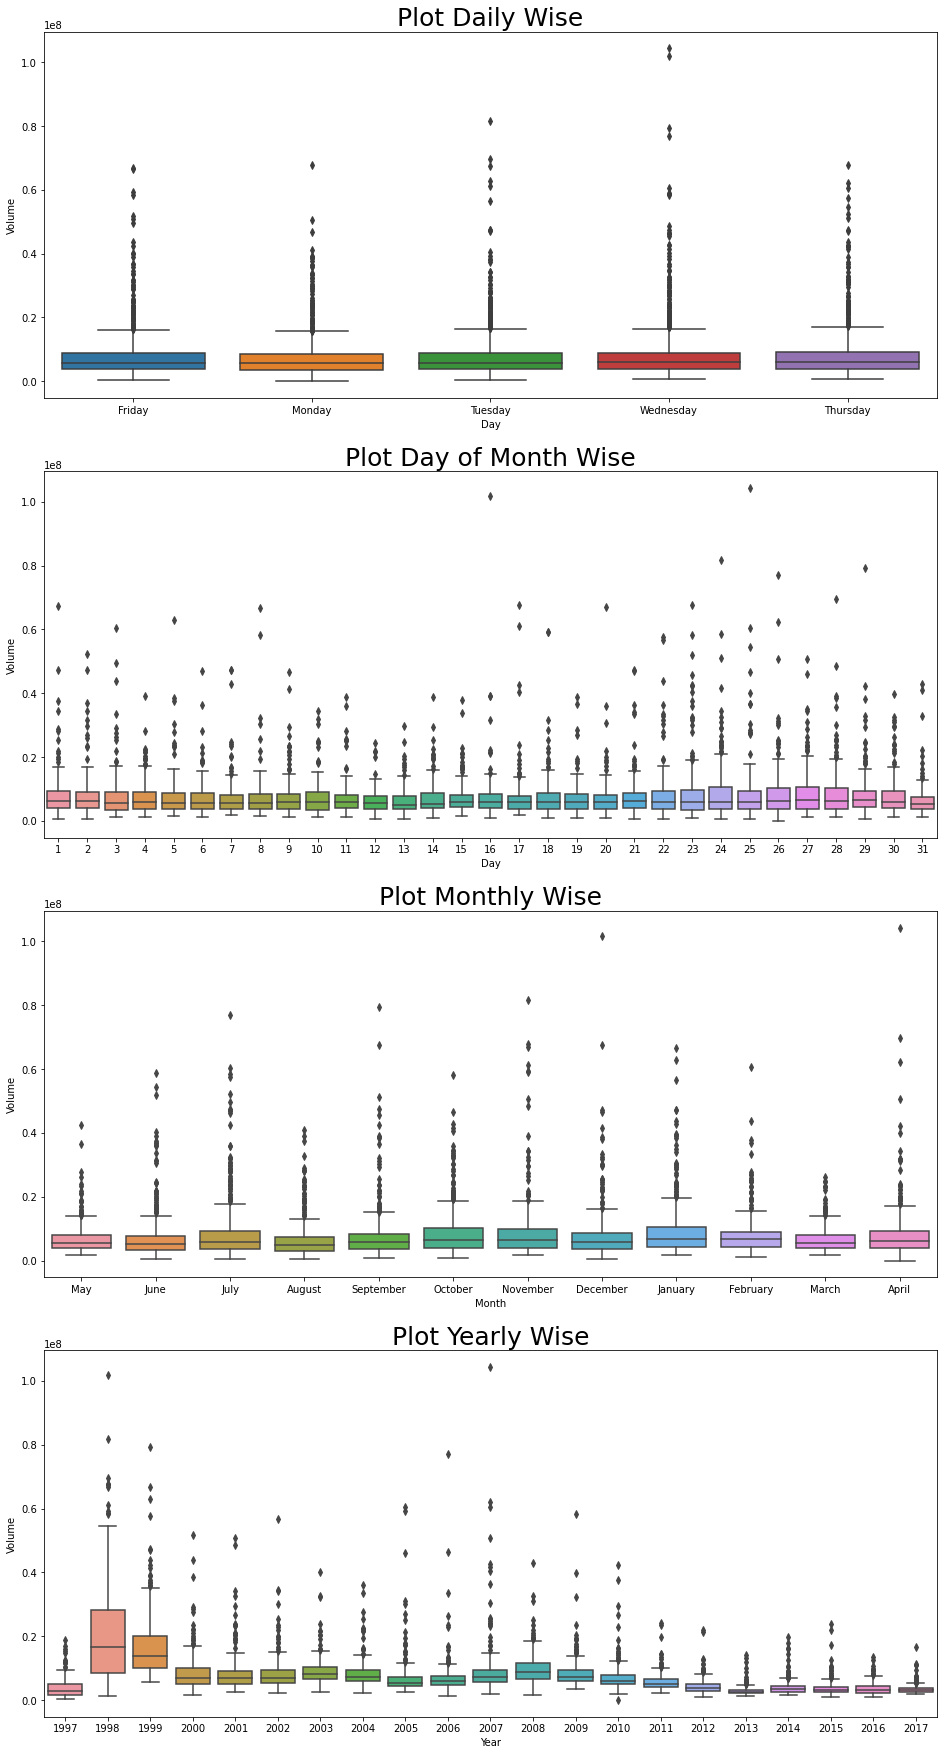

In [24]:
fig, axes = plt.subplots(4)

# Boxplot to view daily volume 
sns.boxplot(data=amazon_data, x='day', y=amazon_data['Volume'], ax = axes[0])
axes[0].set_title("Plot Daily Wise", fontsize=25)
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Volume')

# Boxplot to view day of month volume 
sns.boxplot(data=amazon_data, x='day of month', y=amazon_data['Volume'], ax = axes[1])
axes[1].set_title("Plot Day of Month Wise", fontsize=25)
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Volume')

# Boxplot to view monthly volume 
sns.boxplot(data=amazon_data, x='month', y=amazon_data['Volume'], ax = axes[2])
axes[2].set_title("Plot Monthly Wise", fontsize=25)
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Volume')

# Boxplot to view yearly volume
sns.boxplot(data=amazon_data, x='year', y=amazon_data['Volume'], ax = axes[3])
axes[3].set_title("Plot Yearly Wise", fontsize=25)
axes[3].set_xlabel('Year')
axes[3].set_ylabel('Volume')

fig.set_size_inches(16,31)

Box plots for Volume are shown for Daily, Day of month, monthly and yearly above.

All box plots shown above have outliers above them, indicating that outlier values generally only occured in the higher values of Volume recorded and not for the lower values of Volume recorded. The box plots shown in each individual plot all appear to be faily similar, with the exception of Yearly where the years of 1998 and 1999 have much larger box plot spread than the other years.

# Task 3 - AMZN STR Decomposition
Focus now on the AMZN stock volume time series.

a) Split the data into training and testing series, selecting the testing series to be the last three months of the data.

b) Manually step through the STR decomposition process on the training data, as
described in the course material. Visualise and interpret each of the components of the STR decomposition for volume. (Hint: You may wish to validate the output of your manual process against an automated modelling approach.)

In [25]:
# # Remove all data besides stock volume data
# amazon_data.drop(amazon_data.columns.difference(['Datetime', 'Volume']), axis=1, inplace=True)

div = 5 * 4 * 3 # 5 days a week * 4 weeks a month * 3 months
train_amazon = amazon_data['Volume'][:-div]
test_amazon = amazon_data['Volume'][-div:]
prediction_dates = pd.DataFrame(index=test_amazon.index)

In [26]:
train_amazon

1997-05-16    14700000.0
1997-05-19     6106800.0
1997-05-20     5467200.0
1997-05-21    18853200.0
1997-05-22    11776800.0
                 ...    
2017-08-14     3168518.0
2017-08-15     2544672.0
2017-08-16     3125793.0
2017-08-17     3474358.0
2017-08-18     3276718.0
Freq: B, Name: Volume, Length: 5286, dtype: float64

### Isolate Trend
Since we have a weekly cycle we can roll to 1 and 2 weeks and look at the plot

In [27]:
amazon_data['MA5 Trend'] = amazon_data['Volume'].rolling(5).mean() # 1 week
amazon_data['MA10 Trend'] = amazon_data['Volume'].rolling(10).mean() # 2 week
amazon_data['MA20 Trend'] = amazon_data['Volume'].rolling(20).mean() # 1 month
amazon_data['MA60 Trend'] = amazon_data['Volume'].rolling(60).mean() # 3 months
amazon_data['MA120 Trend'] = amazon_data['Volume'].rolling(120).mean() # 6 months
amazon_data['MA180 Trend'] = amazon_data['Volume'].rolling(180).mean() # 9 months
amazon_data['MA240 Trend'] = amazon_data['Volume'].rolling(240).mean() # 12 months
amazon_data['MA480 Trend'] = amazon_data['Volume'].rolling(480).mean() # 24 months
amazon_data['MA720 Trend'] = amazon_data['Volume'].rolling(720).mean() # 36 months

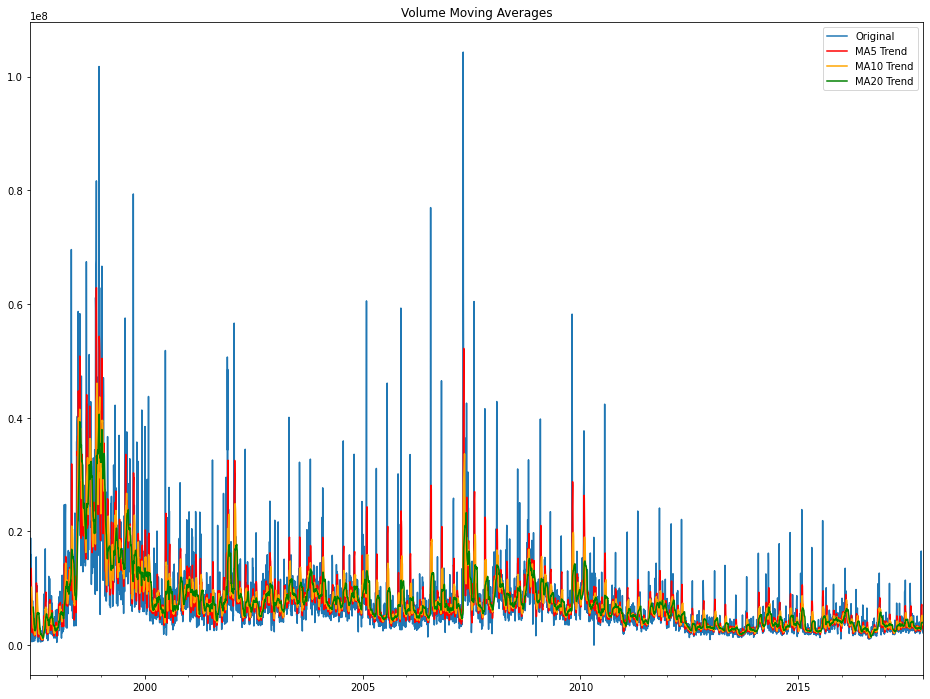

In [28]:
fig, ax = plt.subplots()
amazon_data['Volume'].plot(label='Original', ax=ax)
amazon_data['MA5 Trend'].plot(color='red', label='MA5 Trend', ax=ax)
amazon_data['MA10 Trend'].plot(color='orange', label='MA10 Trend', ax=ax)
amazon_data['MA20 Trend'].plot(color='green', label='MA20 Trend', ax=ax)
# amazon_data['MA60 Trend'].plot(color='orange', label='MA60 Trend', ax=ax)
# amazon_data['MA120 Trend'].plot(color='blue', label='MA60 Trend', ax=ax)
# amazon_data['MA180 Trend'].plot(color='yellow', label='MA60 Trend', ax=ax) # chosen in tut
# amazon_data['MA240 Trend'].plot(color='yellow', label='MA60 Trend', ax=ax)
# amazon_data['MA480 Trend'].plot(color='yellow', label='MA60 Trend', ax=ax)
# amazon_data['MA720 Trend'].plot(color='yellow', label='MA60 Trend', ax=ax)
plt.title('Volume Moving Averages')
fig.set_size_inches((16, 12))
plt.legend()
plt.show()

This graph is way to cluttered, to decide what period length we will loom into a 6 month period

<AxesSubplot:>

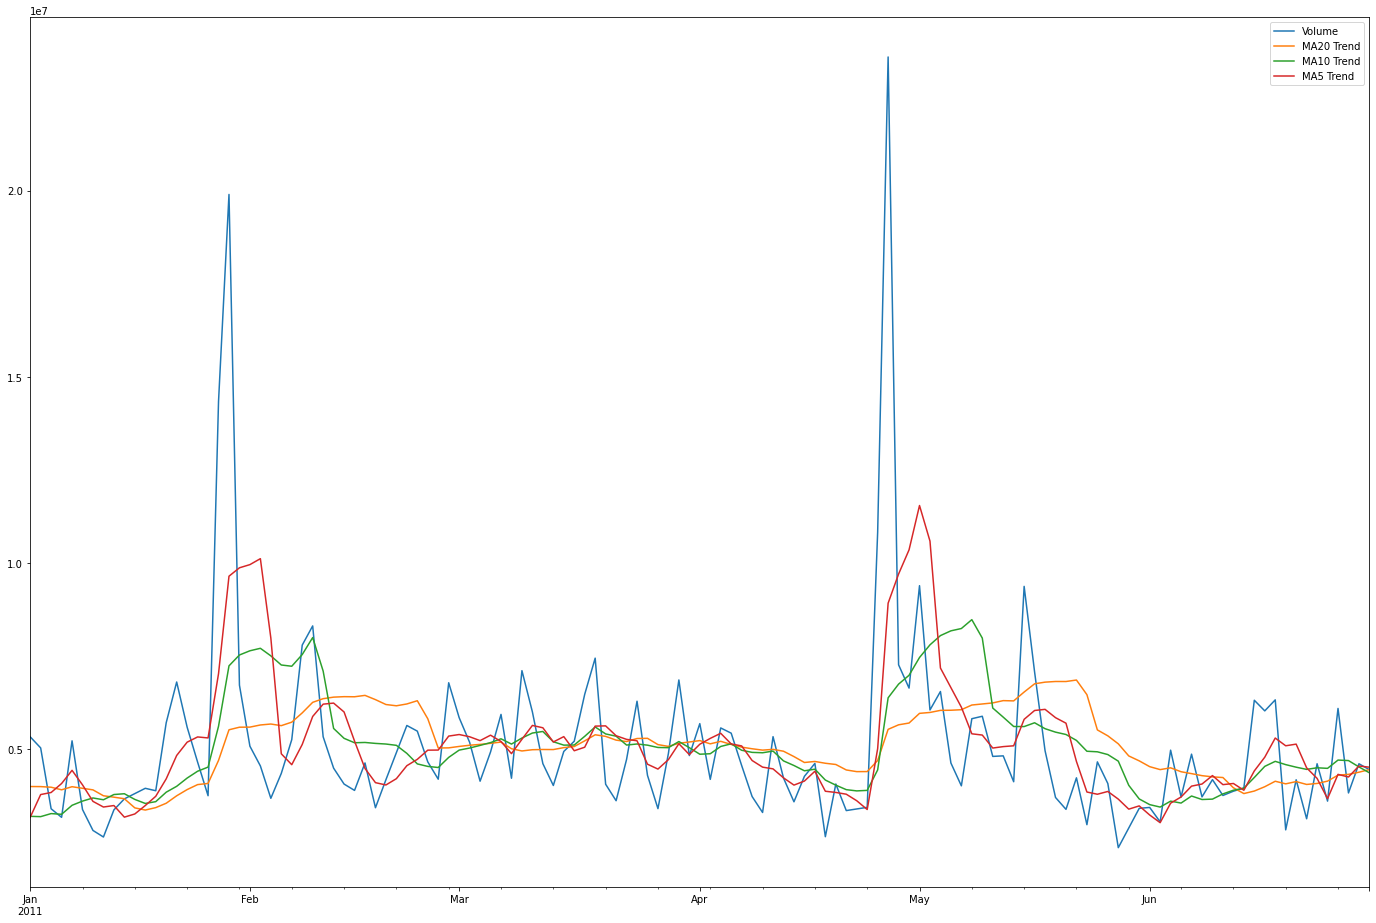

In [29]:
amazon_data['2011-01':'2011-06'][['Volume', 'MA20 Trend', 'MA10 Trend', 'MA5 Trend']].plot(figsize=(24,16))

MA5 (Red) appears to still contain seasonal information as it is not smooth and seems to follow the weekly seasonality. So we wil not pick this one.

MA20 (Yellow) appears to be smoother but seems to lag behind in the change in trends slightly. If you look at the large blue spikes the yellow line is a bit late to follow the trend up and is a bit late in following the trend back down after the large blue spikes.

Therefore we will select MA10 (Green) as the period for the rolling average, as this appears to smooth out the graph and follow the trends well.

In [30]:
rolling_period = 'MA10 Trend'

### Detrend the Series

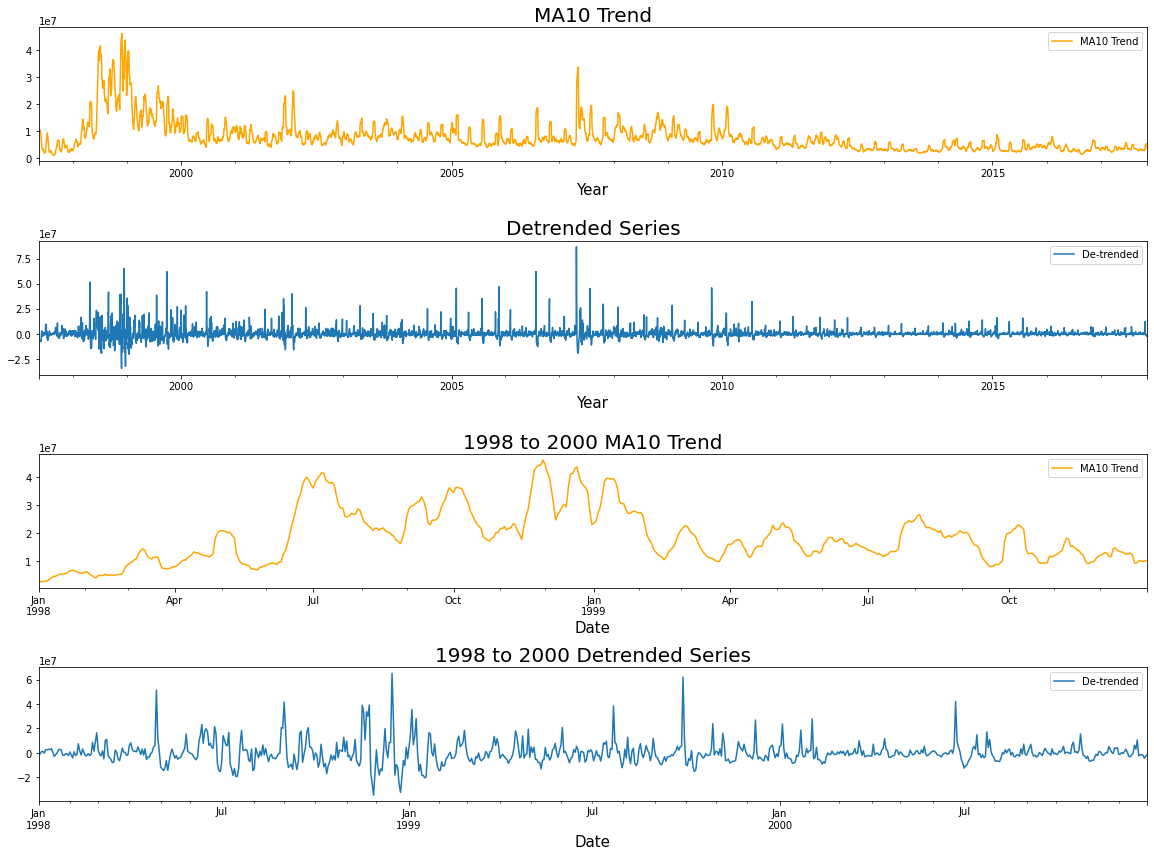

In [31]:
# De-trended data
amazon_data['De-trended'] = amazon_data['Volume'] - amazon_data[rolling_period]

fig, axes = plt.subplots(4)

amazon_data[rolling_period].plot(color='orange', label=rolling_period, ax=axes[0])
axes[0].legend(loc='upper right')
axes[0].set_title("MA10 Trend", fontsize=20)
axes[0].set_xlabel('Year', fontsize=15)

amazon_data['De-trended'].plot(label='De-trended', ax=axes[1])
axes[1].legend(loc='upper right')
axes[1].set_title("Detrended Series", fontsize=20)
axes[1].set_xlabel('Year', fontsize=15)

amazon_data['1998':'1999'][rolling_period].plot(color='orange', label=rolling_period, ax=axes[2])
axes[2].legend(loc='upper right')
axes[2].set_title("1998 to 2000 MA10 Trend", fontsize=20)
axes[2].set_xlabel('Date', fontsize=15)

amazon_data['1998':'2000']['De-trended'].plot(label='De-trended', ax=axes[3])
axes[3].legend(loc='upper right')
axes[3].set_title("1998 to 2000 Detrended Series", fontsize=20)
axes[3].set_xlabel('Date', fontsize=15)

fig.set_size_inches((16, 12))
# fig.legend([])
plt.tight_layout()
plt.show()

The blue plot above represents the detrended component of the 'Volume'. As expected the detrended series appears horizontal with some larger values around the beginning of the timeline when the MA10 trend shows a large spike.

### Estimate seasonal component

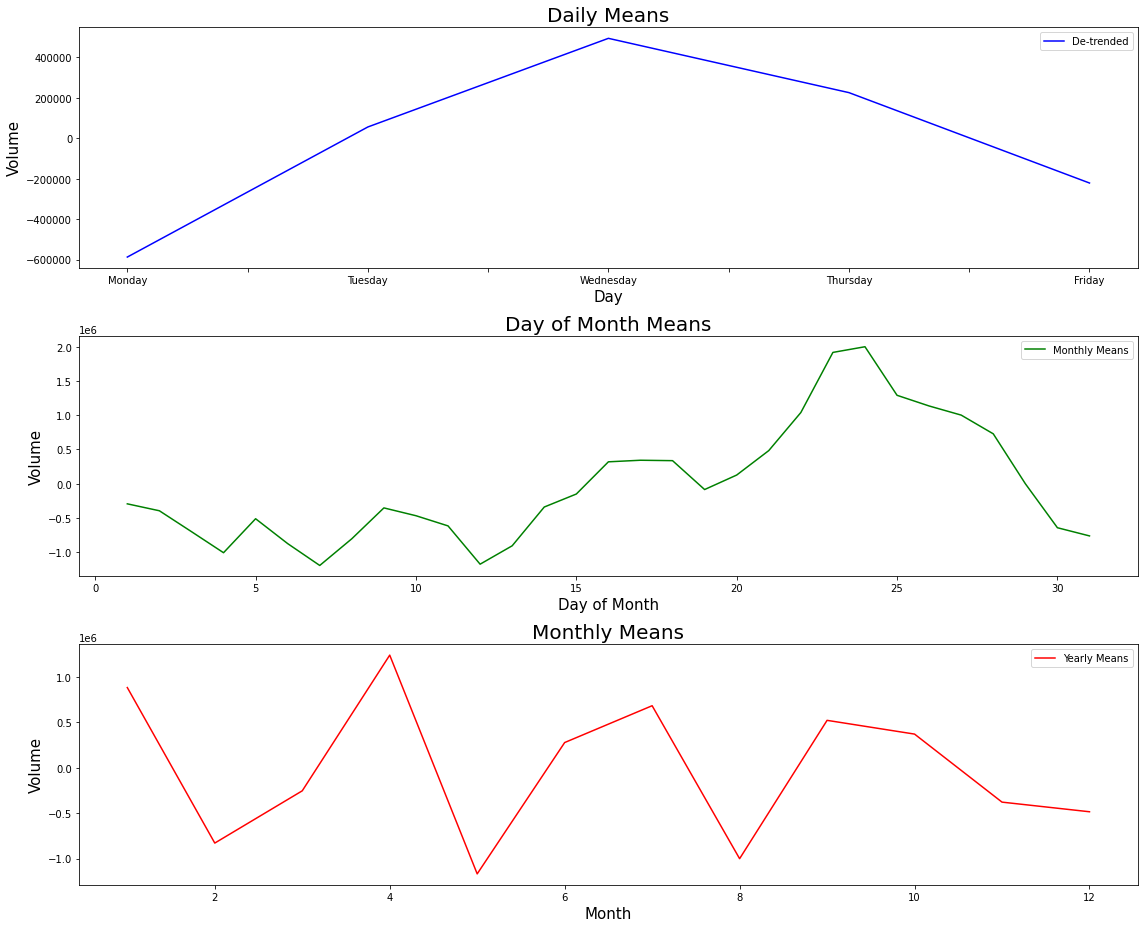

In [32]:
# https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.dayofweek.html
# https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.dayofweek.html
# https://sparkbyexamples.com/pandas/pandas-remap-values-in-column-with-a-dictionary-dict/
# https://stackoverflow.com/questions/40427943/how-do-i-change-a-single-index-value-in-pandas-dataframe

fig, axes = plt.subplots(3)

# Calculate Daily means and order from Monday to Friday
raw_daily_means = amazon_data.groupby(amazon_data.index.dayofweek)['De-trended'].mean()
raw_daily_means = raw_daily_means.to_frame()
raw_daily_means = raw_daily_means.rename(index={0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4:'Friday'})
# raw_daily_means.plot()

# Test seasonal component for monthly data
raw_monthly_means = amazon_data.groupby(amazon_data.index.day)['De-trended'].mean()
raw_yearly_means = amazon_data.groupby(amazon_data.index.month)['De-trended'].mean()

raw_daily_means.plot(label='Daily Means', ax=axes[0], color='b')
axes[0].legend(loc='upper right')
axes[0].set_title("Daily Means", fontsize=20)
axes[0].set_xlabel('Day', fontsize=15)
axes[0].set_ylabel('Volume', fontsize=15)

raw_monthly_means.plot(label='Monthly Means', ax=axes[1], color='g')
axes[1].legend(loc='upper right')
axes[1].set_title("Day of Month Means", fontsize=20)
axes[1].set_xlabel('Day of Month', fontsize=15)
axes[1].set_ylabel('Volume', fontsize=15)

raw_yearly_means.plot(label='Yearly Means', ax=axes[2], color='r')
axes[2].legend(loc='upper right')
axes[2].set_title("Monthly Means", fontsize=20)
axes[2].set_xlabel('Month', fontsize=15)
axes[2].set_ylabel('Volume', fontsize=15)

fig.set_size_inches((16,13))
plt.tight_layout()

Weekly recordings are the clearest option for a seasonal period as the daily means graph shows a clear cycle from Monday to Friday. However, you could also consider the Day of Month Means to also show seasonality with the Volume gradually increasing to a spike around the 25th of the month.

Further calculations will use the Daily Means as the seasonality component, with a season length of 5.

In [33]:
season_length = len(raw_daily_means.index)

Seasonal Components need to sum to zero, we will introduce an adjustment

In [34]:
# Shift values so that seasonal components sum to zero
adjustment = raw_daily_means.sum()/season_length
daily_means = raw_daily_means - adjustment

# Convert df to series
daily_means = daily_means.squeeze()

Now we fill the series for the entire duration of the timeseries
1. Get the lenth of the seasonal data input equal to the length of df_temp
2. Start the seasonal data at the correct time step

In [35]:
# tile the values into the dataframe so that the entire series is filled
seasonal = np.tile(daily_means, int(np.floor(len(amazon_data)/season_length)))

print(f"seasonal length = {len(seasonal)}  amazon_data = {len(amazon_data)}")

seasonal length = 5345  amazon_data = 5346


There is one day missing from the seasonal tiled series length.

In [36]:
amazon_data['day'].head()

1997-05-16       Friday
1997-05-19       Monday
1997-05-20      Tuesday
1997-05-21    Wednesday
1997-05-22     Thursday
Freq: B, Name: day, dtype: object

The dataset starts on a Friday but the tiled seasonal series starts on a Monday so we need to add a recording for a Friday onto the start of the Seasonal series.

In [37]:
 # Prepending one observation
seasonal = np.insert(seasonal, 0, daily_means[season_length - 1])

amazon_data['temp-seasonal'] = seasonal

<AxesSubplot:>

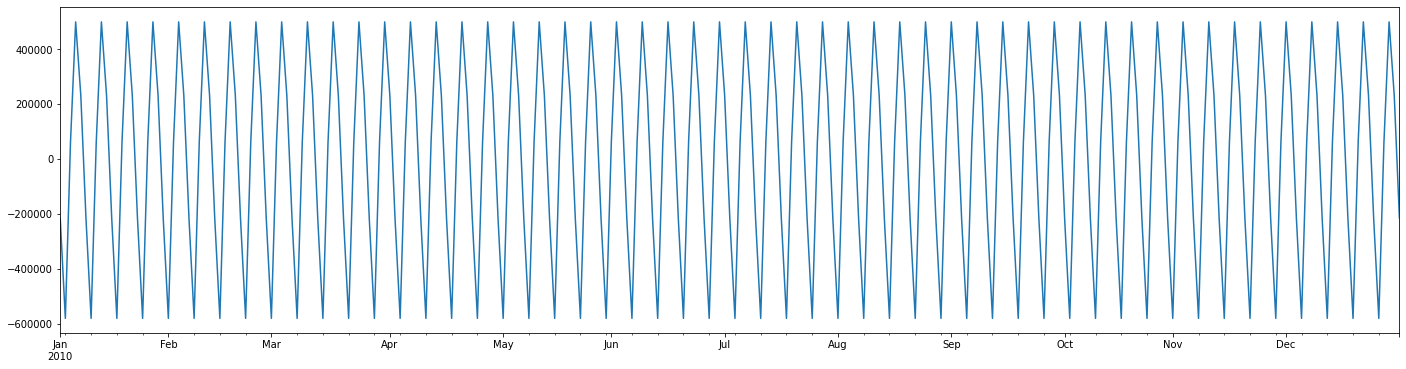

In [38]:
amazon_data['2010':'2010']['temp-seasonal'].plot(figsize=(24,6))

### Calculate the residual component
The last step is to calulate the residual, by subtracting the seasonal component from the detrended data.

<AxesSubplot:>

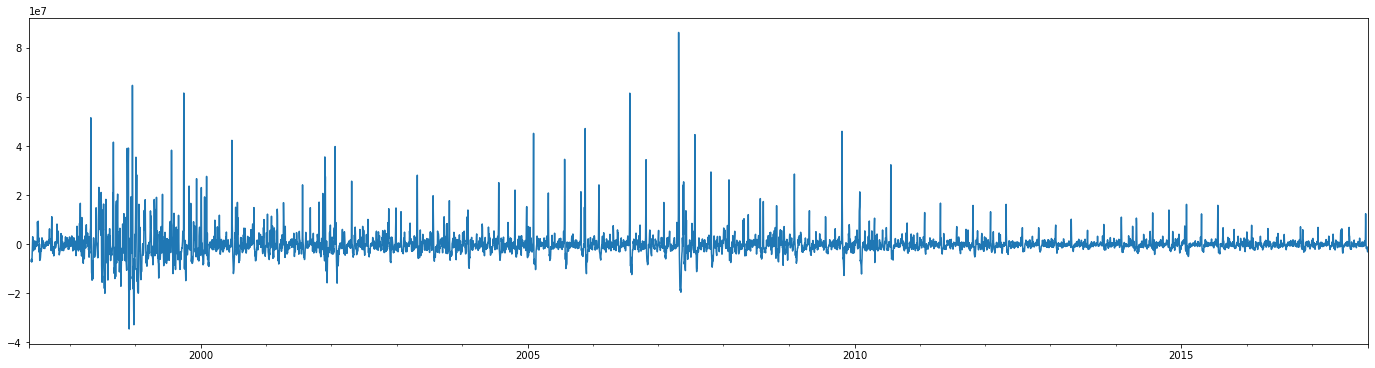

In [39]:
amazon_data['temp-residual'] = amazon_data['De-trended'] - amazon_data['temp-seasonal']
amazon_data['temp-residual'].plot(figsize=(24,6))

This residual component is expected as it is horisontal and shows no obvious seasonality.

### Compare Manual STR with Automated Modeling Approach

Below we will plot all 4 plots from the manual STR process in the same figure

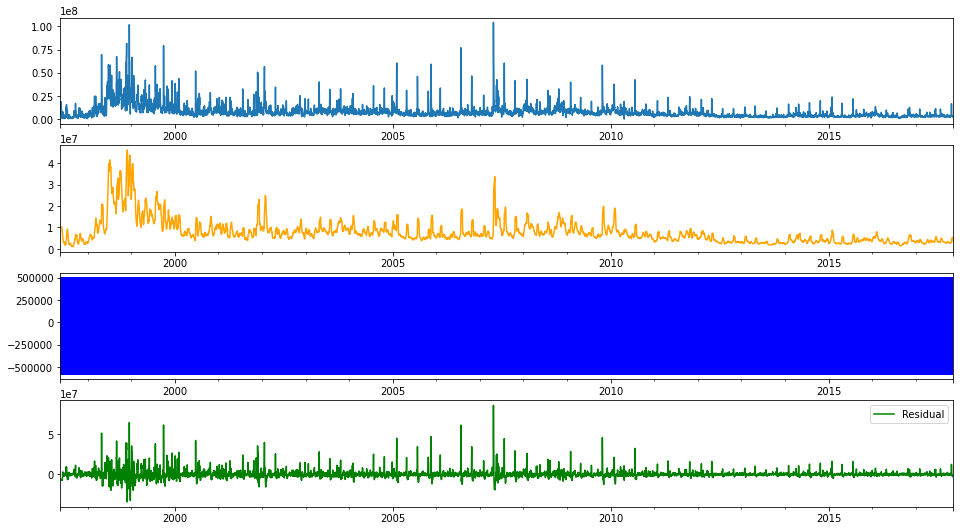

In [40]:
fig, ax_str = plt.subplots(4)
amazon_data['Volume'].plot(label='Original', ax=ax_str[0])
amazon_data['MA10 Trend'].plot(color='orange', label='MA10 Trend', ax=ax_str[1])
amazon_data['temp-seasonal'].plot(color='blue', label='Seasonal', ax=ax_str[2])
amazon_data['temp-residual'].plot(color='green', label= 'Residual', ax=ax_str[3])
fig.set_size_inches((16, 9))
plt.legend()
plt.show()

Next we will also show the result of an automated STR decomposition process

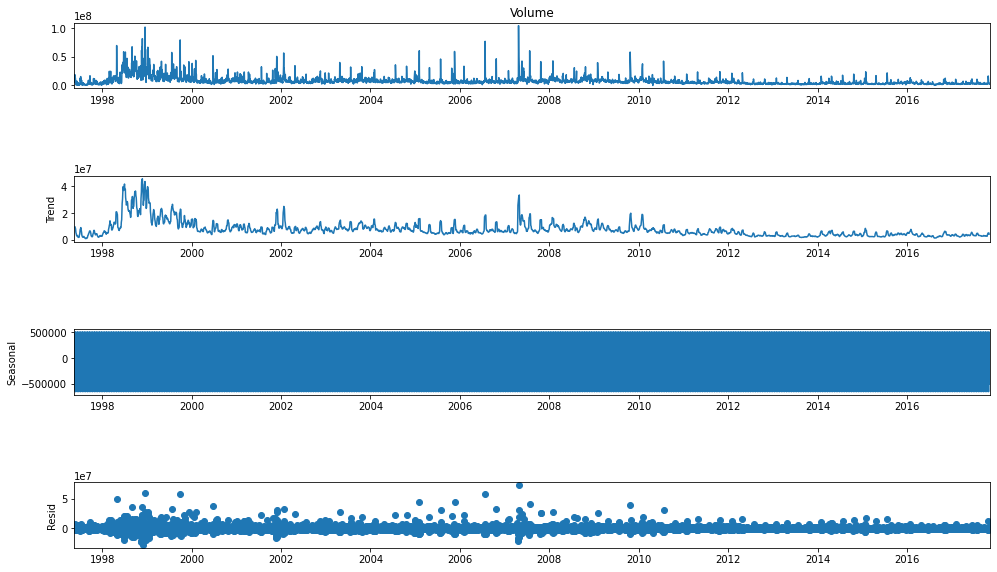

In [41]:
# Jumping ahead - automatic decomposition of temp
from statsmodels.tsa.seasonal import seasonal_decompose

str_res = seasonal_decompose(amazon_data['Volume'], period=10)
fig = str_res.plot()
fig.set_size_inches((16, 9))

The two sets of plots above are very similar.

The Volume, Trend, seasonal and Residual plots for both the manual process and the automatic STR decomposition appear to be very similar indicating that the manual process was done correctly.

We will zoom into a one month period for the manual and automatic process for further validation.

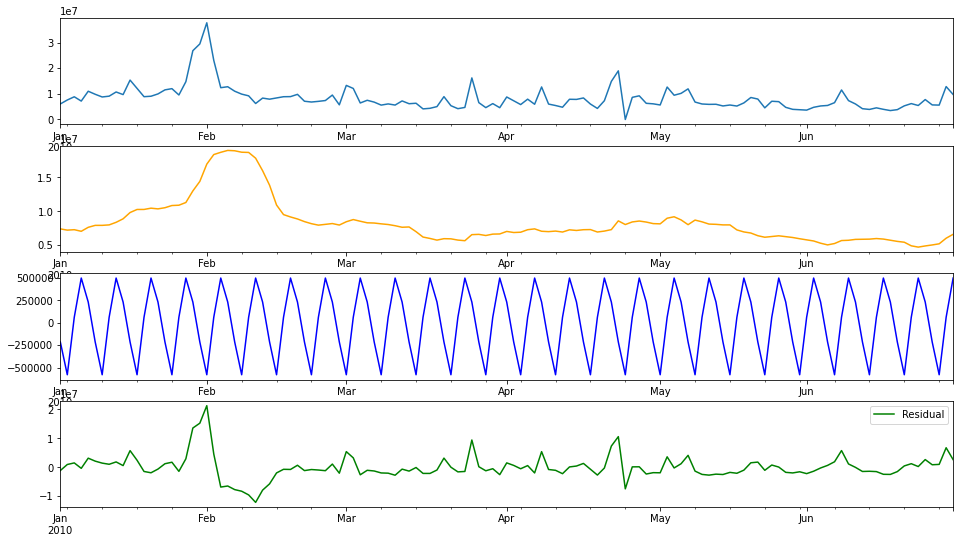

In [42]:
fig, ax_str = plt.subplots(4)
amazon_data['Volume']["2010-01":"2010-06"].plot(label='Original', ax=ax_str[0])
amazon_data['MA10 Trend']["2010-01":"2010-06"].plot(color='orange', label='MA10 Trend', ax=ax_str[1])
amazon_data['temp-seasonal']["2010-01":"2010-06"].plot(color='blue', label='Seasonal', ax=ax_str[2])
amazon_data['temp-residual']["2010-01":"2010-06"].plot(color='green', label= 'Residual', ax=ax_str[3])
fig.set_size_inches((16, 9))
plt.legend()
plt.show()

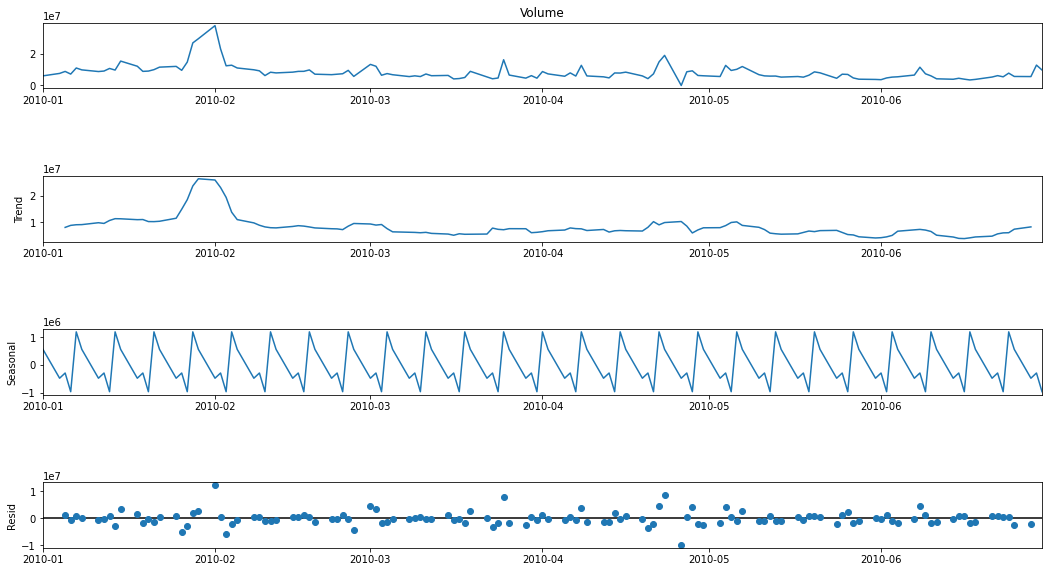

In [43]:
str_res = seasonal_decompose(amazon_data["2010-01":"2010-06"]['Volume'])
fig = str_res.plot()
fig.set_size_inches((16, 9))

The two plots showing the manual and automatic STR process for the first 6 months of 2010 show similar graphs again for Volume and Trend.

However, the automatic process has generated a slightly different seasonal component.

# Task 4 - Timeseries Models
a) Fit an ARIMA model for the trend-cycle component of your STR decomposition of the training data and interpret the estimated model parameters.

b) Using the STR components that you estimated in tasks 3 and 4, produce forecasts of AMZN stock volumes for the test data series. Include the uncertainty in the forecasts and visualise the predictions.

### Check for stationarity
To fig an autoregressive model or an ARIMA model that contains an AR component, the data must be stationary. The criteria for stationarity is that the data is:
- roughly horizontal
- constant variance
- no patterns predictable in the long-term

<AxesSubplot:>

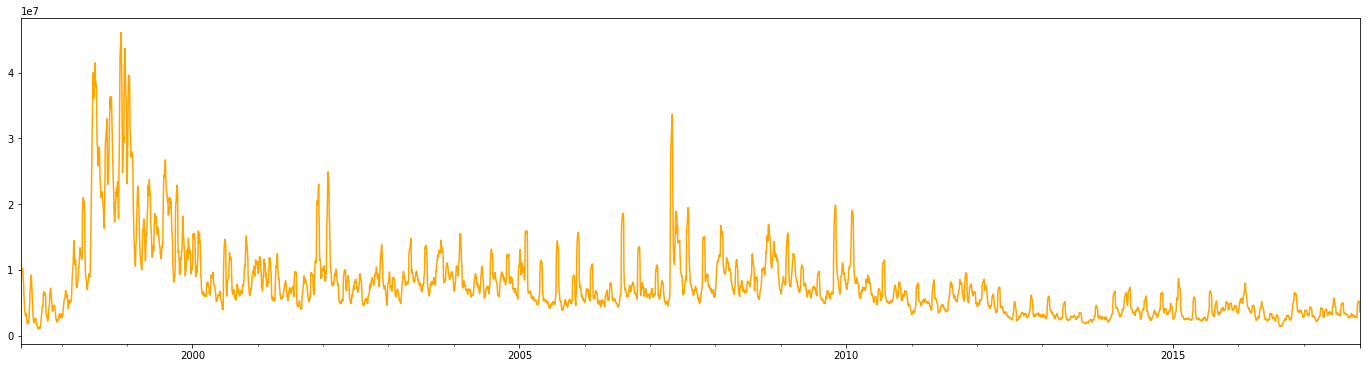

In [44]:
amazon_data[rolling_period].plot(color='orange', figsize=(24,6))

We can see from the above plot that the data is non statinary as it increases and decreases over the whole period and does not have a constant variance.

Therefore the data requires differencing to produce more stationary data.

<AxesSubplot:>

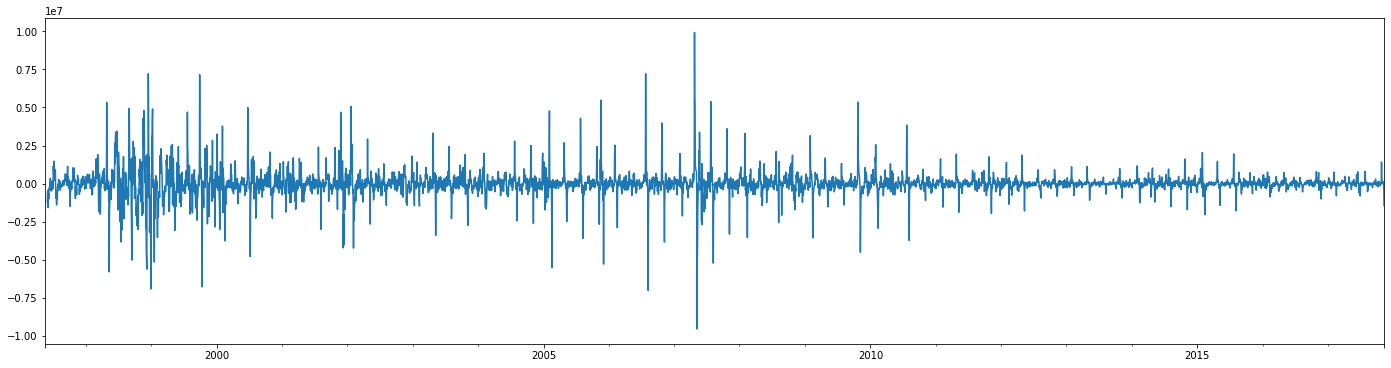

In [45]:
# Perform first differencing
trend_d1 = amazon_data[rolling_period].diff()
trend_d1.plot(figsize=(24,6))

<AxesSubplot:>

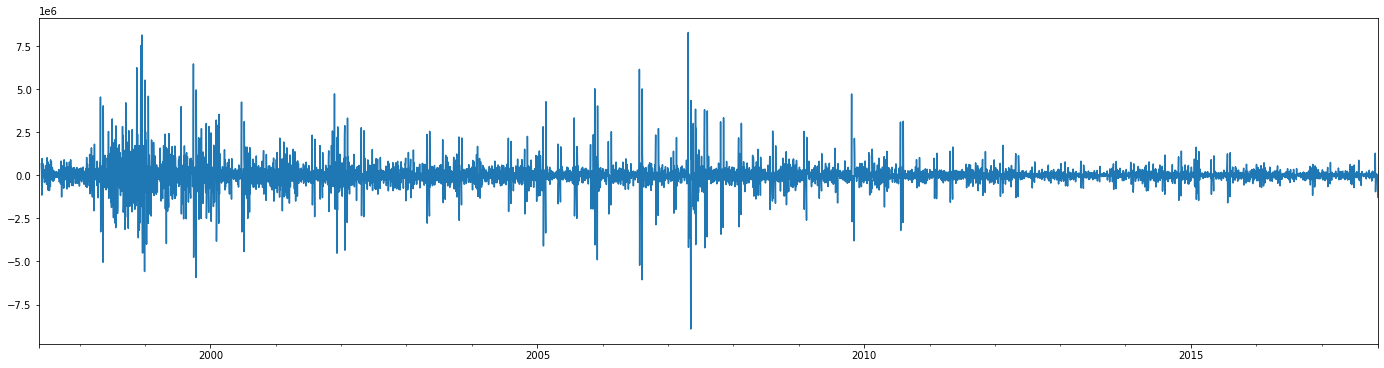

In [46]:
# Perform second differencing
trend_d2 = trend_d1.diff()
trend_d2.plot(figsize=(24,6))

We have performed differencing twice to see if there are significant changes to the data.

The differencing plot does not seem to change significantly when going from first to second differencing.

Therefore, we will select the first differencing. 

d = 1

## Fit a lower order model

In [47]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm

## Is there Evidence of autocorrelation?
We will use ACF and PCF plots to check for evidene of autocorrelation in the differenced data.

In [48]:
trend_d1.head(11)

1997-05-16          NaN
1997-05-19          NaN
1997-05-20          NaN
1997-05-21          NaN
1997-05-22          NaN
1997-05-23          NaN
1997-05-26          NaN
1997-05-27          NaN
1997-05-28          NaN
1997-05-29          NaN
1997-05-30   -1210560.0
Freq: B, Name: MA10 Trend, dtype: float64

In [49]:
# trim th nan's from the differenced trend
trend_d1 = trend_d1[10:].copy()

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


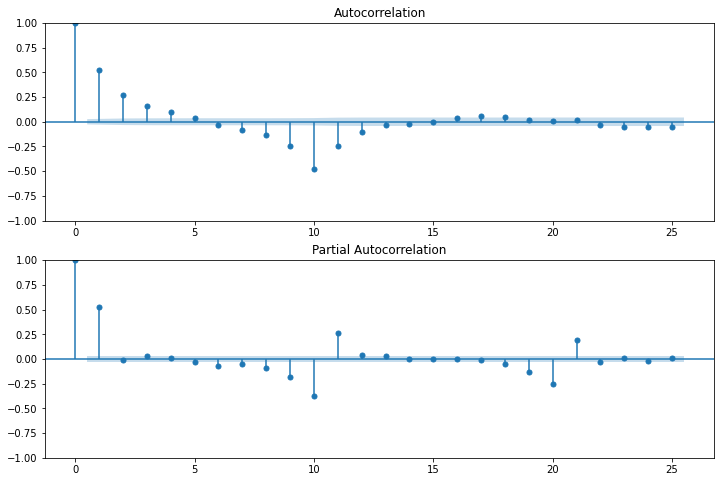

In [50]:
# Generate ACF and PCF plots
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(trend_d1, lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(trend_d1, lags=25, ax=ax2)

From the ACF plot (first) the plot drops to zero quickly inidicating a stationary time series.

### Fit the ARIMA Model

In [51]:
amazon_data[rolling_period].head(10)

1997-05-16           NaN
1997-05-19           NaN
1997-05-20           NaN
1997-05-21           NaN
1997-05-22           NaN
1997-05-23           NaN
1997-05-26           NaN
1997-05-27           NaN
1997-05-28           NaN
1997-05-29    10190340.0
Freq: B, Name: MA10 Trend, dtype: float64

In [52]:
arima_train = amazon_data[rolling_period][9:-div]
arima_test = amazon_data[rolling_period][-div:]

In [53]:
arima_1_1_0 = ARIMA(arima_train, order=(1, 1, 0)).fit()
print(arima_1_1_0.summary())

                               SARIMAX Results                                
Dep. Variable:             MA10 Trend   No. Observations:                 5277
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -78441.994
Date:                Sat, 05 Nov 2022   AIC                         156887.988
Time:                        14:01:44   BIC                         156901.130
Sample:                    05-29-1997   HQIC                        156892.581
                         - 08-18-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5032      0.004    112.204      0.000       0.494       0.512
sigma2      4.724e+11   8.38e-16   5.64e+26      0.000    4.72e+11    4.72e+11
Ljung-Box (L1) (Q):                   2.60   Jarque-

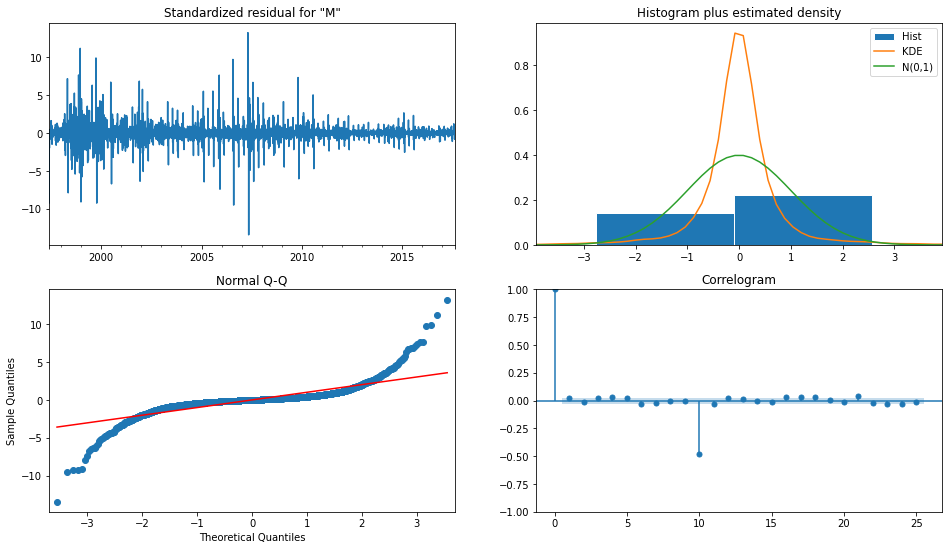

In [54]:
fig = plt.figure(figsize=(16, 9))
fig = arima_1_1_0.plot_diagnostics(fig=fig, lags=25)

In [55]:
arima_2_1_0 = ARIMA(arima_train, order=(2, 1, 0)).fit()
print(arima_2_1_0.summary())

                               SARIMAX Results                                
Dep. Variable:             MA10 Trend   No. Observations:                 5277
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -78441.883
Date:                Sat, 05 Nov 2022   AIC                         156889.765
Time:                        14:01:46   BIC                         156909.478
Sample:                    05-29-1997   HQIC                        156896.656
                         - 08-18-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5066      0.006     79.058      0.000       0.494       0.519
ar.L2         -0.0062      0.009     -0.730      0.465      -0.023       0.010
sigma2      4.725e+11   5.76e-15   8.21e+25      0.0

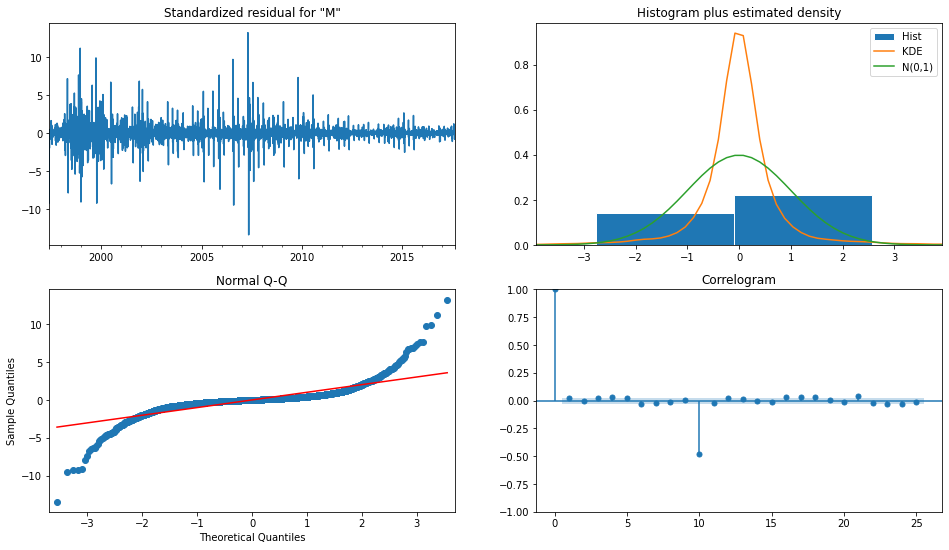

In [56]:
fig = plt.figure(figsize=(16, 9))
fig = arima_2_1_0.plot_diagnostics(fig=fig, lags=25)

### Comparing Goodness of fit of ARIMA models

Looking at the outputs for the ARIMA models above: 
- AIC for ARIMA(1,1,0) = 156887, for ARIMA(2,1,0) = 156889
- BIC for ARIMA(1,1,0) = 156901, for ARIMA(2,1,0) = 156909

There is a small increase in AIC and BIC between the two models. Lower AIC and BIC is prefered so we will select ARIMA(1,1,0)

Next we will see if ARIMA(1,1,1) gives us any improvements

In [57]:
arima_1_1_1 = ARIMA(arima_train, order=(1, 1, 1)).fit()
print(arima_1_1_1.summary())

                               SARIMAX Results                                
Dep. Variable:             MA10 Trend   No. Observations:                 5277
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -78441.885
Date:                Sat, 05 Nov 2022   AIC                         156889.769
Time:                        14:01:49   BIC                         156909.482
Sample:                    05-29-1997   HQIC                        156896.659
                         - 08-18-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4930      0.013     37.390      0.000       0.467       0.519
ma.L1          0.0140      0.017      0.829      0.407      -0.019       0.047
sigma2      4.723e+11   1.89e-14    2.5e+25      0.0

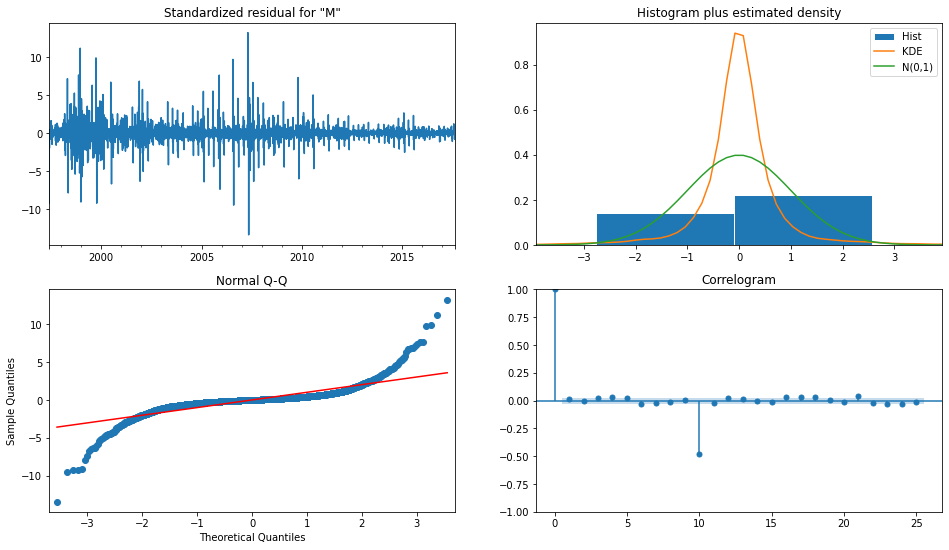

In [58]:
fig = plt.figure(figsize=(16, 9))
fig = arima_1_1_1.plot_diagnostics(fig=fig, lags=25)

Looking at the outputs: 
- AIC for ARIMA(1,1,0) = 156887, for ARIMA(1,1,1) = 164199
- BIC for ARIMA(1,1,0) = 156901, for ARIMA(1,1,1) = 164218

This time there is a large increase in AIC and BIC between ARIMA(1,1,0) and ARIMA(1,1,1). Lower AIC and BIC is prefered so we will go with ARIMA(1,1,0)

### Inspect the residuals

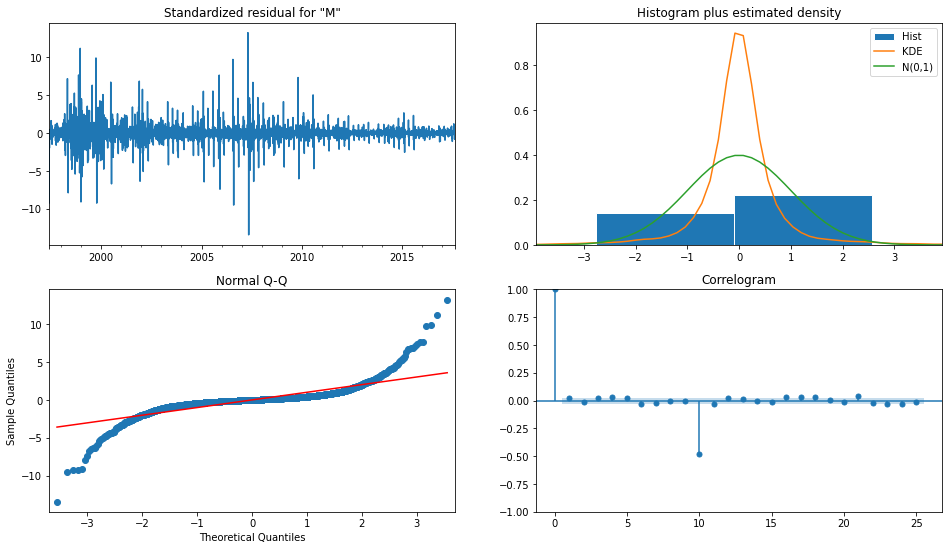

In [59]:
fig = plt.figure(figsize=(16, 9))
fig = arima_1_1_0.plot_diagnostics(fig=fig, lags=25)

The histogram is showing a normally distrubuted residuals and the correlogram has a large drop at the start and hovers near and within the blue shaded area signifying no autocorrelation.

In [60]:
arima_pred = pd.DataFrame(index=test_amazon.index)

In [61]:
arima_pred['Trend'] = arima_1_1_0.predict(start="2017-08-21", end="2017-11-10")

In [62]:
arima_pred['Seasonal'] = ''
for t in range(len(arima_pred)):
    arima_pred['Seasonal'][t] = arima_pred['Trend'][t] + raw_daily_means['De-trended'][np.mod(t,5)]

/tmp/ipykernel_850032/3984504411.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arima_pred['Seasonal'][t] = arima_pred['Trend'][t] + raw_daily_means['De-trended'][np.mod(t,5)]


#### Plot ARIMA Prediction

/tmp/ipykernel_850032/2968444456.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  arima_pred['2017']['Trend'].plot(color='red', label='ARIMA(4,1,2) Forecast', ax=ax_arma)
/tmp/ipykernel_850032/2968444456.py:6: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  arima_pred['2017']['Seasonal'].plot(color='blue', label='ARIMA + Seasonal Forecast', ax=ax_arma)


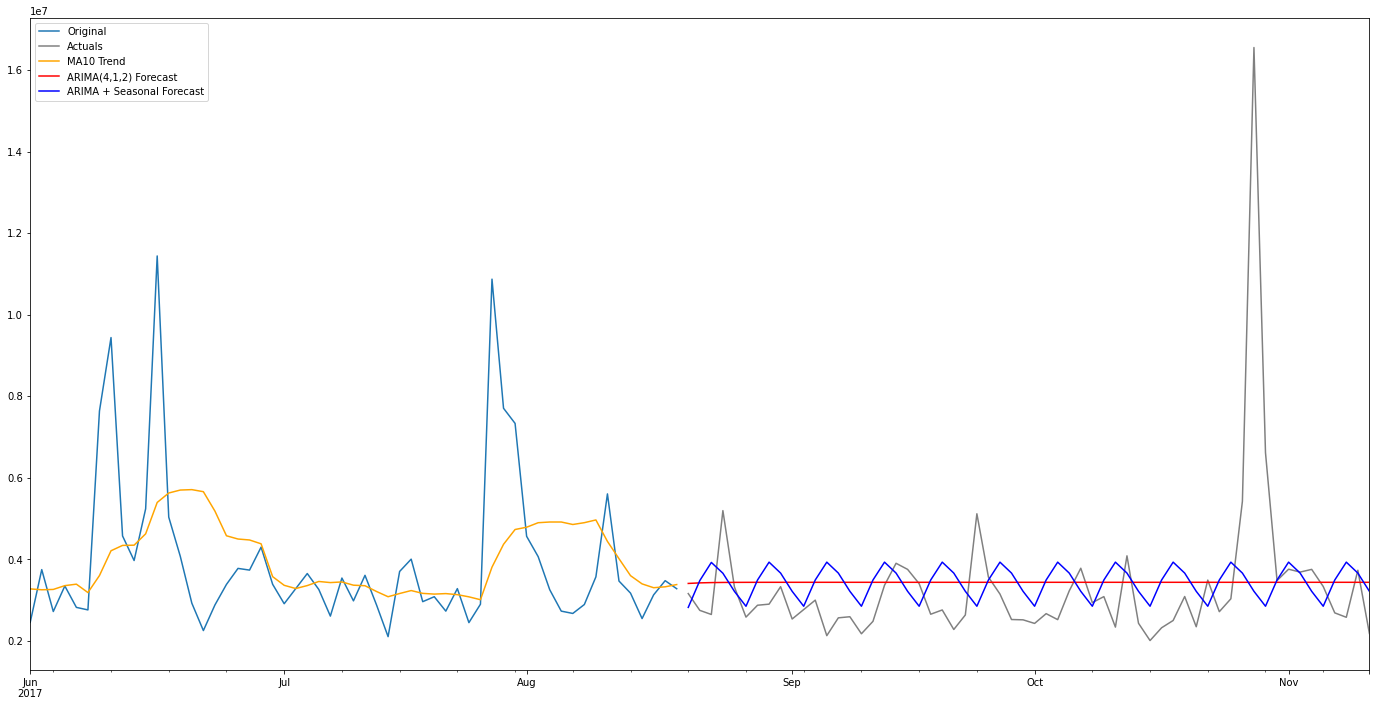

In [63]:
fig, ax_arma = plt.subplots(figsize=(24,12))
train_amazon['2017-06':'2017'].plot(label='Original', ax=ax_arma)
test_amazon.plot(color='grey', label='Actuals', ax=ax_arma)
amazon_data['2017-06':'2017'][rolling_period][:-div].plot(color='orange', label='MA10 Trend', ax=ax_arma)
arima_pred['2017']['Trend'].plot(color='red', label='ARIMA(4,1,2) Forecast', ax=ax_arma)
arima_pred['2017']['Seasonal'].plot(color='blue', label='ARIMA + Seasonal Forecast', ax=ax_arma)
plt.legend()

The results of the arima model show a horizontal trend that sits a bit to high above the actual recordings. ARIMA seasonal component is a simple tiled out weekly seasonal component we calculated earlier. In real life the Volume has some randomness to it that we were not able to capture using a simple trend + seasonal component. A more advanced model may be required to capture the randomness of the seasonal component better. However for a simple forcast this can be useful.

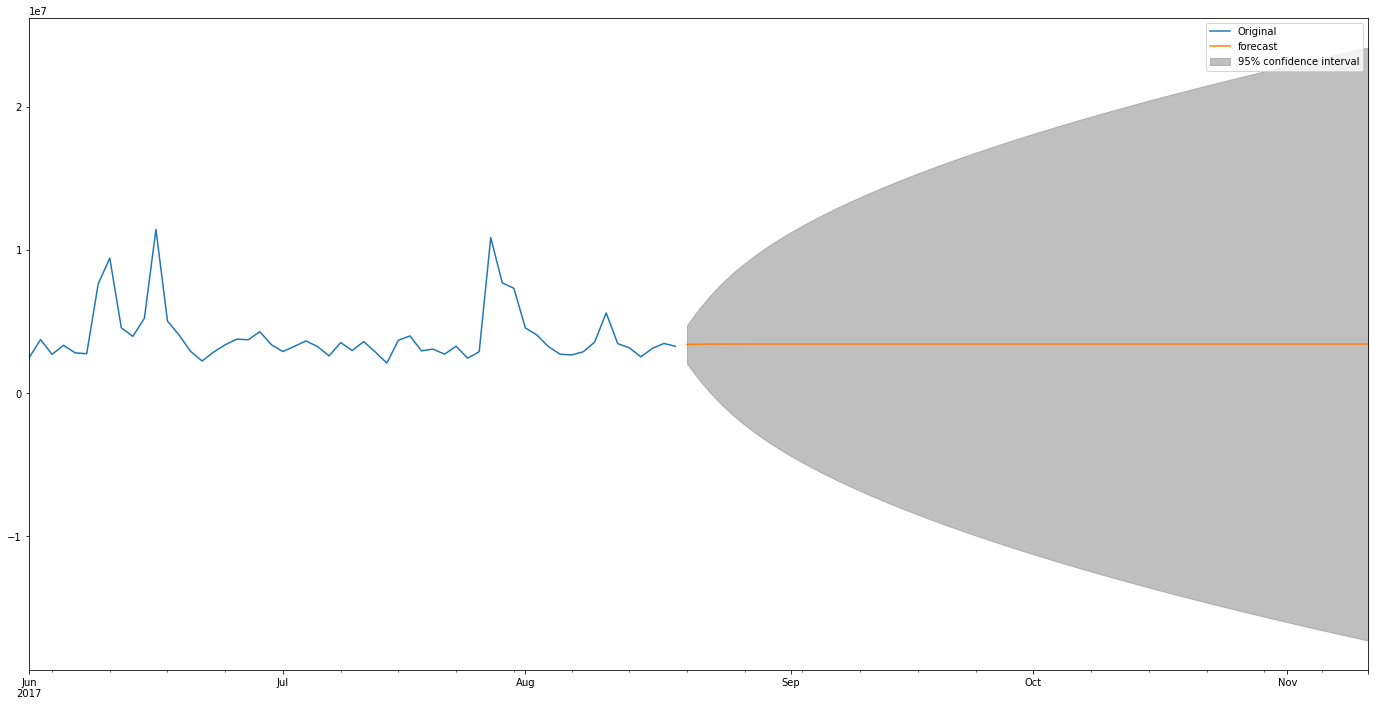

In [64]:
fig, ax_arma = plt.subplots(figsize=(24,12))
train_amazon['2017-06':'2017'].plot(label='Original', ax=ax_arma)
fig = plot_predict(arima_1_1_0, start="2017-08-21", end="2017-11-10", label='ARIMA(1,1,0) Forecast', ax=ax_arma)

The trend and 95% confidence interval is shown above, the 95% confidence interval is shown to grow very quickly indicating the randomness that the arima model is unable to capture. This indicates the ARIMA model may only be useful for a short prediction horizon.

# Task 5 - Pure Forcasters
now consider your choice of ML techniques

a) Select an appropriate pure forecasting method to predict the trend component of the volume training data.

b) Using the seasonal component that you estimated in task 3 and the pure forecaster from 5.a, produce forecasts of AMZN stock volumes for the test data series. Include the uncertainty in the forecasts, and visualise the predictions.

In [65]:
# !pip3 uninstall tensorflow-cpu -y
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

2022-11-05 14:01:54.104727: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-05 14:01:54.303142: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-05 14:01:54.303197: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-05 14:01:54.335692: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-05 14:01:55.210911: W tensorflow/stream_executor/platform/de

Scale the data and split into train test.

We will use the previous 5 observations of the volume as the features used to predict future values

In [66]:
# We will use the previous 5 observations of the volume as the features used to predict future values
prev_data = pd.concat([amazon_data['Volume'], 
                 amazon_data['Volume'].shift(), 
                 amazon_data['Volume'].shift(2),
                 amazon_data['Volume'].shift(3),
                 amazon_data['Volume'].shift(4),
                 amazon_data['Volume'].shift(5)], 
                 axis=1
                 ).dropna()

In [67]:
amazon_np_arr = np.array(prev_data)

In [68]:
train, test = amazon_np_arr[:-div], amazon_np_arr[-div:]

# Scale
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.fit_transform(test)

# training data
y_train = train_scaled[:,0]
X_train = train_scaled[:,1:]

# test data
y_test_scaled = test_scaled[:,0]
X_test_scaled = test_scaled[:,1:]

In [69]:
train_scaled

array([[0.15275942, 0.11288163, 0.18070953, 0.05240358, 0.0585342 ,
        0.14090076],
       [0.11806333, 0.15275942, 0.11288163, 0.18070953, 0.05240358,
        0.0585342 ],
       [0.08336724, 0.11806333, 0.15275942, 0.11288163, 0.18070953,
        0.05240358],
       ...,
       [0.02996099, 0.0243909 , 0.03037052, 0.03321121, 0.05370532,
        0.03420096],
       [0.03330202, 0.02996099, 0.0243909 , 0.03037052, 0.03321121,
        0.05370532],
       [0.03140762, 0.03330202, 0.02996099, 0.0243909 , 0.03037052,
        0.03321121]])

In [70]:
# Configure model
learning_rate = 0.001

For this Neural Network a 2 layer model is chosen as it provides a slightly more accurate model over the single layer version. The hidden dimension and number of layers has been chosen as it provided an adequate accuracy able to compute in a reasonable time.

In [71]:
# Single layer FF network with RLU
def slff_relu(input_dim,hidden_1_dim = 80):
    # Single-layer FF network with Rectified linear unit (relu) activation fxn
    inputs = keras.layers.Input(shape=(input_dim))
    hidden_layer_1 = keras.layers.Dense(hidden_1_dim, activation='relu')(inputs)
    hidden_layer_2 = keras.layers.Dense(hidden_1_dim, activation='relu')(hidden_layer_1)
    outputs = keras.layers.Dense(1,activation='tanh')(hidden_layer_2)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [72]:
# Input dimensions = 5 to match the seasonality
input_dim = 5
model = slff_relu(input_dim)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense (Dense)               (None, 80)                480       
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 1)                 81        
                                                                 
Total params: 7,041
Trainable params: 7,041
Non-trainable params: 0
_________________________________________________________________


2022-11-05 14:01:56.484903: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-05 14:01:56.485029: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-05 14:01:56.485087: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (data2001-5d7daac5.zones.eait.uq.edu.au): /proc/driver/nvidia/version does not exist
2022-11-05 14:01:56.485650: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-05 14:01:56.612526: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Al

In [73]:
# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=20, shuffle=False)

2022-11-05 14:01:56.712586: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 105620 exceeds 10% of free system memory.


Epoch 1/100


2022-11-05 14:01:56.840333: W tensorflow/core/platform/profile_utils/cpu_utils.cc:118] Failed to find bogomips or clock in /proc/cpuinfo; cannot determine CPU frequency
2022-11-05 14:01:56.854182: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 42248 exceeds 10% of free system memory.


265/265 [==============================] - 2s 3ms/step - loss: 0.0025
Epoch 2/100
265/265 [==============================] - 1s 3ms/step - loss: 0.0024
Epoch 3/100
265/265 [==============================] - 1s 3ms/step - loss: 0.0024
Epoch 4/100
265/265 [==============================] - 1s 3ms/step - loss: 0.0024
Epoch 5/100
265/265 [==============================] - 1s 3ms/step - loss: 0.0025
Epoch 6/100
265/265 [==============================] - 1s 3ms/step - loss: 0.0025
Epoch 7/100
265/265 [==============================] - 1s 3ms/step - loss: 0.0025
Epoch 8/100
265/265 [==============================] - 1s 3ms/step - loss: 0.0025
Epoch 9/100
265/265 [==============================] - 1s 5ms/step - loss: 0.0025
Epoch 10/100
265/265 [==============================] - 1s 3ms/step - loss: 0.0025
Epoch 11/100
265/265 [==============================] - 1s 3ms/step - loss: 0.0025
Epoch 12/100
265/265 [==============================] - 1s 3ms/step - loss: 0.0025
Epoch 13/100
265/265 [===

### Timeseries predictions using neural networks

In [74]:
y_pred = model.predict(X_test_scaled)
# y_pred = [x for [x] in y_pred]

2/2 [==============================] - 0s 3ms/step


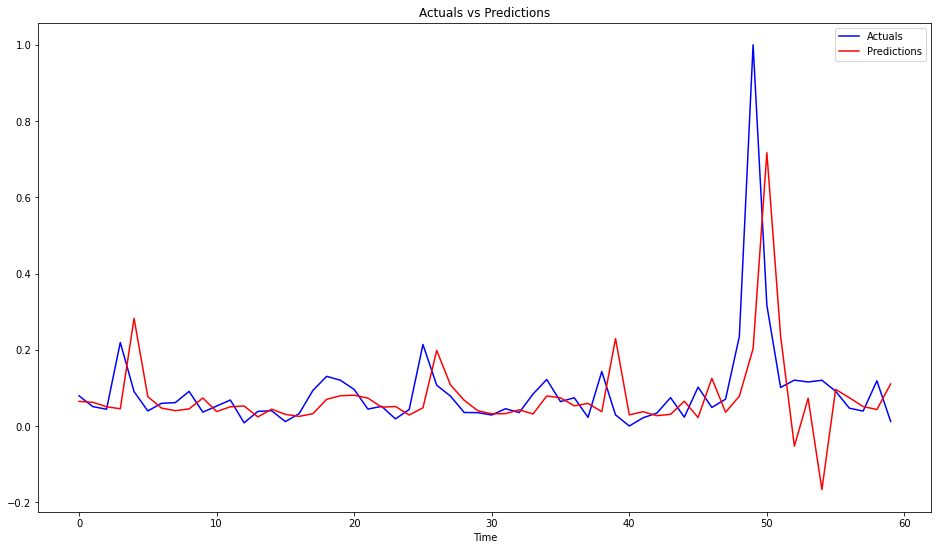

In [75]:
# Plot test data predictions
def plot_pred(y_test,y_pred,period=60):
    plt.figure(figsize=(16,9))
    plt.plot(y_test[-period:], "b", label="Actuals")
    plt.plot(y_pred[-period:], "r", label="Predictions")
    plt.title("Actuals vs Predictions")
    plt.xlabel("Time")
    plt.legend()
    plt.show()

plot_pred(y_test_scaled,y_pred)

The Single step predicition above appears to be quite accurate. However, it also appears to be lagging a bit ad the predicted peaks all fal behind the actual peaks.

To get a sense of the goodness of these predictions, we compute and plot the test data errors

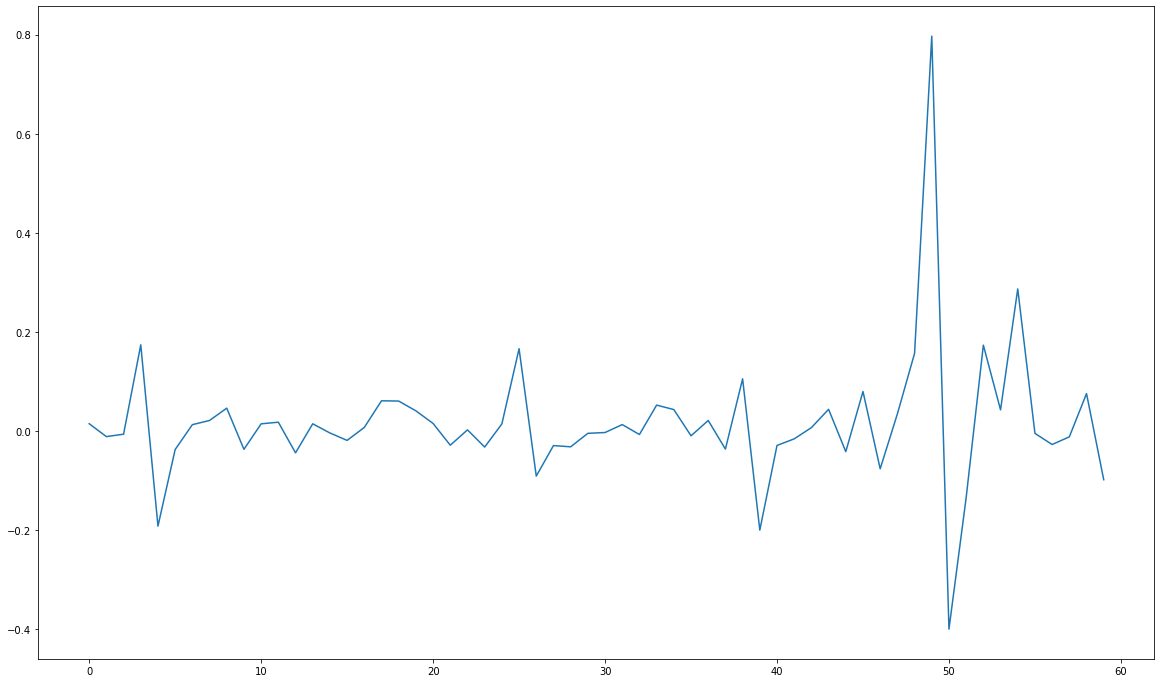

In [76]:
# Compute and plot the test data errors
errors = np.squeeze(y_test_scaled) - np.squeeze(y_pred)
plt.figure(figsize=(20,12))
plt.plot(errors)
# plt.figsize=(24,12))

You can conduct further analysis into the test data errors, for example corellograms to ascertain if there is any correlation, or checks of whether the errors are close to normally distributed.

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


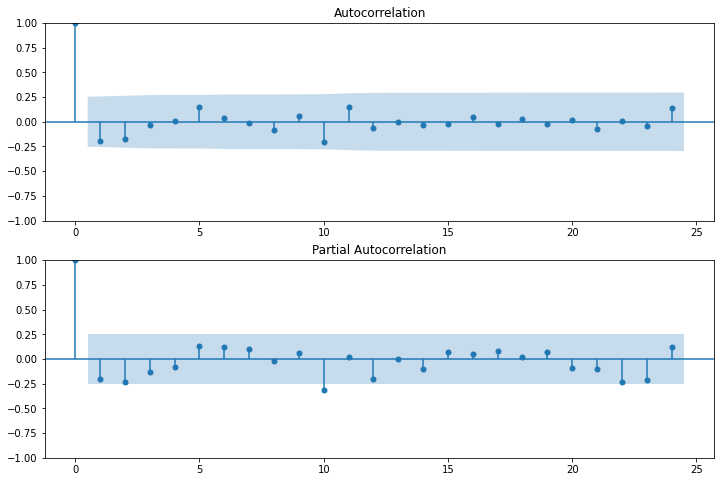

In [77]:
# check for evidence of autocorrelation
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(errors, lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(errors, lags=24, ax=ax2)

Both correlelograms above show no evidence of autocorrelation in the errors.

{'whiskers': [<matplotlib.lines.Line2D at 0x7fff14657a90>,
 'caps': [<matplotlib.lines.Line2D at 0x7fff14666070>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fff146577c0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fff14666610>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fff146668e0>],
 'means': []}

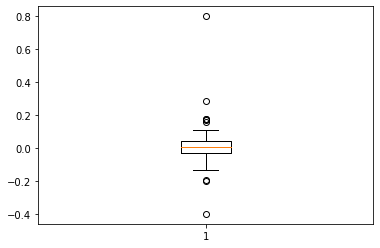

In [78]:
fig, ax = plt.subplots()
ax.boxplot(errors)

The errors are shown to be approximately normally distributed with few outliers.

### Multistep point prediction

In [79]:
def multistep_prediction(H, model, X_pred,residuals=[]):
    # Initialise lists for storing multi-step predictions
    y_pred_multi = []
    X_pred_multi = []

    for t in range(H):
        # get next prediction
        X_pred = np.array(X_pred.reshape(1,len(X_pred)))
        new_y= float(model.predict(X_pred))
#         print("new_y")
#         print(new_y)
    
        # update 
        y_pred_multi.append(float(new_y))
        X_pred_multi.append(list(X_pred[0])) 
#         print("y_pred_multi")
#         print(y_pred_multi)
#         print("X_pred_multi")
#         print(X_pred_multi)
    
        # prepare net input with bootstrapped training residuals
        X_pred = X_pred_multi[t][:-1]
        if len(residuals) == 0:
            X_pred.insert(0,new_y)
        else:
            X_pred.insert(0,(new_y+np.random.choice(residuals)))
        X_pred = np.array(X_pred)
#         print("new X")
#         print(X_pred)
        
    return y_pred_multi, X_pred_multi

1/1 [==============================] - 0s 48ms/step


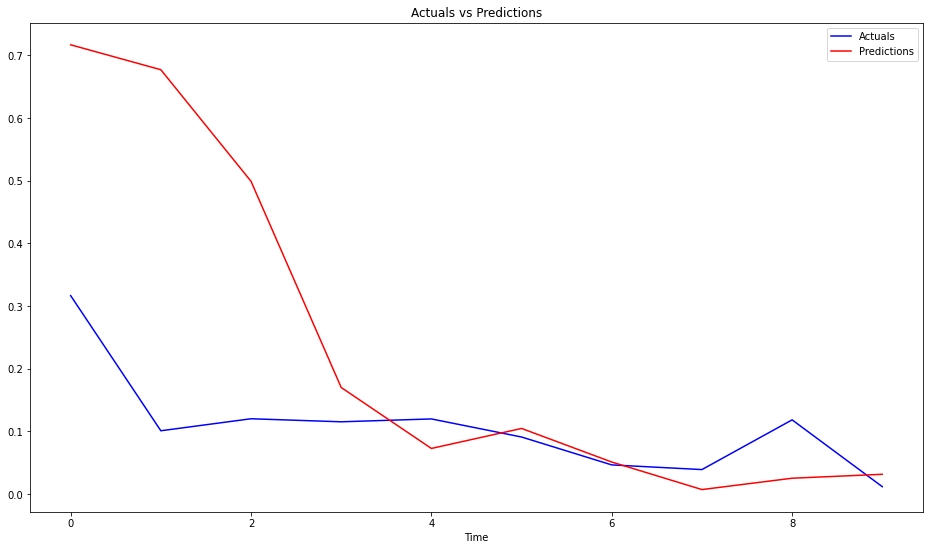

In [80]:
# Prediction horizon
H = 10 # extend prediction horizon to end of dataset

X_test_multi = X_test_scaled[-H:,:]
y_test_multi = y_test_scaled[-H:]
# y_pred_multi = model.predict(X_test_multi)    
# plot_pred(y_test_multi,y_pred_multi)

# Prepare first input to multistep prediction loop
X_pred = X_test_multi[0,:]

# Multistep prediction
y_pred_multi, X_pred_multi = multistep_prediction(H,model,X_pred)
plot_pred(y_test_multi, y_pred_multi, period=H)

A 10 day predicition horzon is shown above, the predicition appears to follow the actual value quite well.

## Bootstrapping for interval predictions
Bootstrapping will be done twice for two different horizon forcasts since it takes too long to compute the full test horizon of 3 months with the high number of bootstrap iterations (100).

The first bootstrap will be for H=10 and k=100 (High number of iterations for a short prediction horizon)

The second bootstrap will be for H=60 and k=10 (Low number of iterations for a the full prediciton horizon)

In [81]:
errors = np.squeeze(y_train) - np.squeeze(model.predict(X_train))

166/166 [==============================] - 0s 1ms/step


### Short Horizon Bootstrap (H=10, k=100)

In [82]:
# Bootstrap iterations
K = 100
H = 10

# Prepare first input to multistep bootsrtap loop
X_pred = X_test_multi[0,:]
y_pred_bootstrap_short = []

# Use multistep prediction to generate bootstrap data, 
# List of training residuals to sample from passed in as fourth argument 

for k in range(K):
    y_pred_multi_short, X_pred_multi_short = multistep_prediction(H,model,X_pred,errors)
    # store y predictions
    y_pred_bootstrap_short.append(y_pred_multi_short)

1/1 [==============================] - 0s 50ms/step


### Visualising bootstrapped interval forcasts

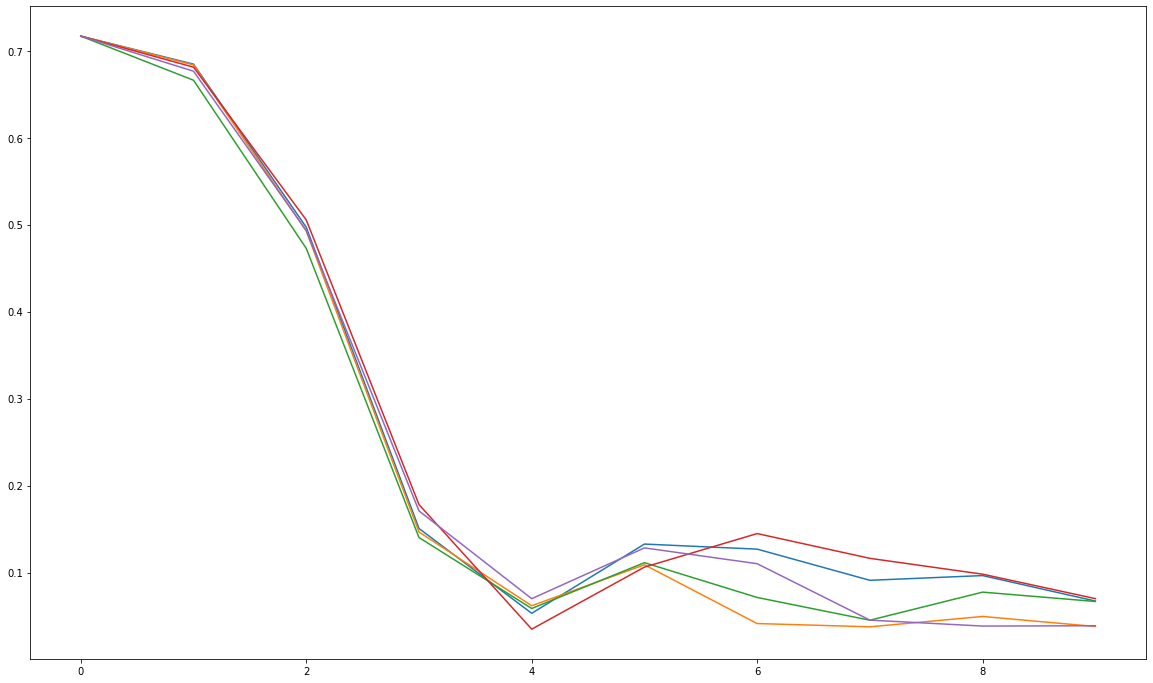

In [83]:
# Useful utility method for transposing lists of lists    
def transposed_2d_list(l):
    return [[row[i] for row in l] for i in range(len(l[0]))]    

plt.figure(figsize=(20,12))
plt.plot(transposed_2d_list(y_pred_bootstrap_short[-5:]))

5 of the bootstrapped predicitions are shown above, in general they all follow a similar path,

In [84]:
bootstrap_predictions_short = pd.DataFrame(index = prev_data.index.values[-H:])

for pctl in range(0,101,10):
    bootstrap_predictions_short[str(pctl)] = np.percentile(y_pred_bootstrap_short,pctl,axis=0)

bootstrap_predictions_short.rename(columns={'50': "median"}, inplace=True)
bootstrap_predictions_short['actuals'] = y_test_scaled[-H:]

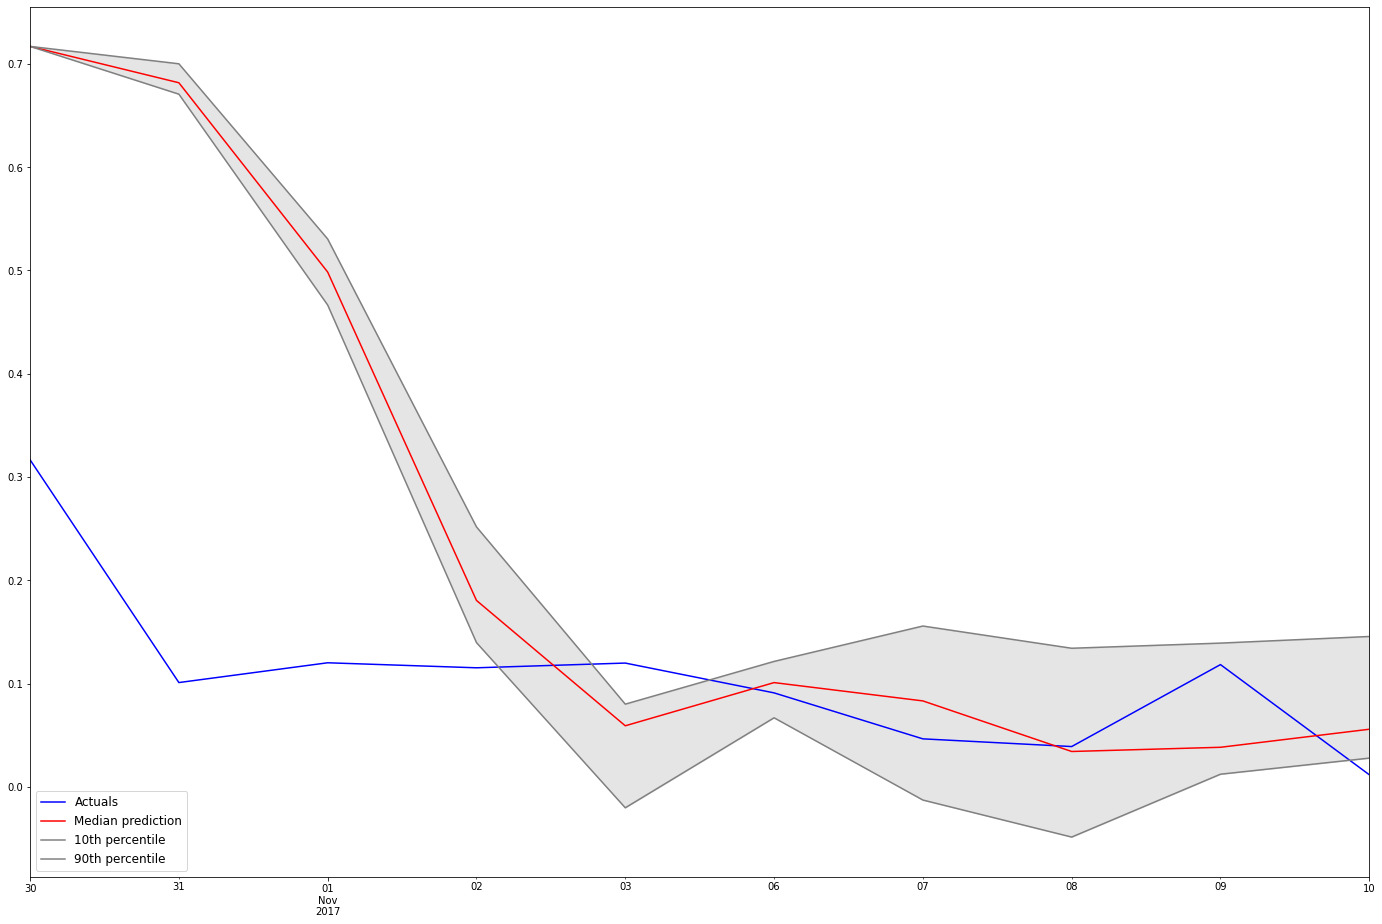

In [85]:
# plot interval with fill
fig, ax_bootstrap = plt.subplots(figsize=(24,16))
bootstrap_predictions_short['actuals'].plot(color = 'blue', label='Actuals', axes=ax_bootstrap)
bootstrap_predictions_short['median'].plot(color = 'red',label = 'Median prediction', axes=ax_bootstrap )
bootstrap_predictions_short['10'].plot(color = 'grey', label = '10th percentile', axes=ax_bootstrap )
bootstrap_predictions_short['90'].plot(color = 'grey', label = '90th percentile', axes=ax_bootstrap )
plt.legend(loc = 'lower left', fontsize = 12)

x = prev_data.index.values[-H:]
plt.fill_between(x, bootstrap_predictions_short['10'], bootstrap_predictions_short['90'], color='grey', alpha=0.2)

The 10th and 90th percentile produces by the bootstrap process is shaded in grey above. The actual line appears to start below the bootstrap region but later falls within the 10th and 90th percentile range.

### Long Horizon Bootstrap (H=60, k=20)

In [86]:
# Bootstrap iterations
K = 10
H = 60

# Prepare first input to multistep bootsrtap loop
X_pred = X_test_multi[0,:]
y_pred_bootstrap_long = []

# Use multistep prediction to generate bootstrap data, 
# List of training residuals to sample from passed in as fourth argument 

for k in range(K):
    y_pred_multi_long, X_pred_multi_long = multistep_prediction(H,model,X_pred,errors)
    # store y predictions
    y_pred_bootstrap_long.append(y_pred_multi_long)

1/1 [==============================] - 0s 49ms/step


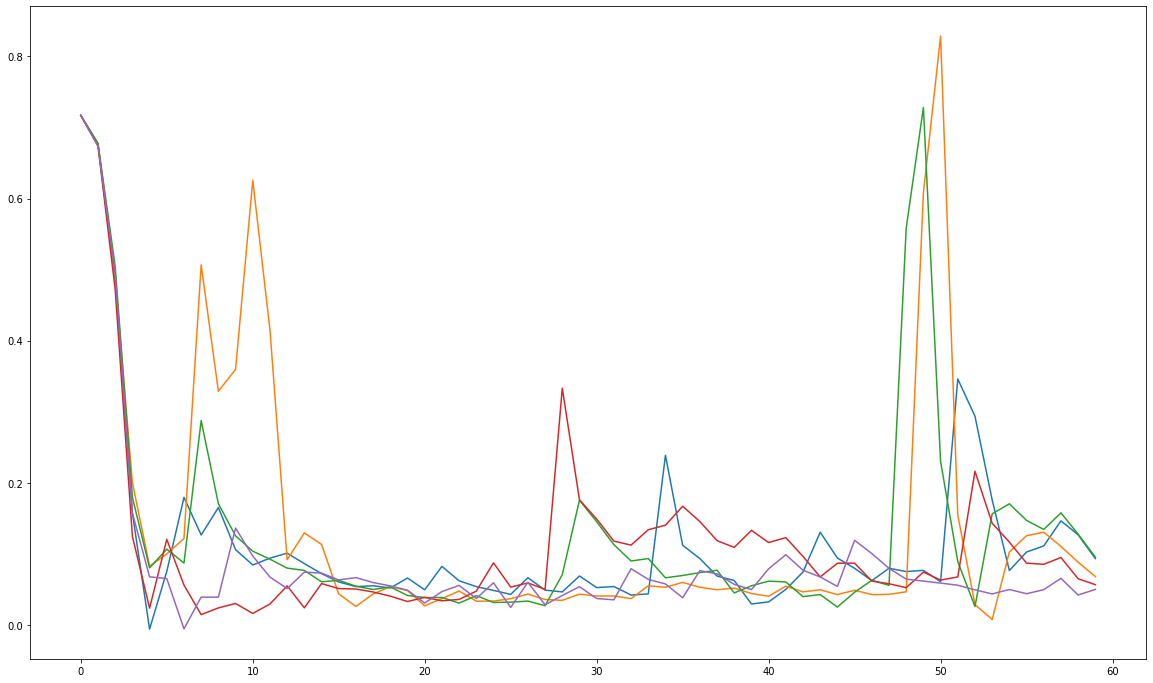

In [87]:
plt.figure(figsize=(20,12))
plt.plot(transposed_2d_list(y_pred_bootstrap_long[-5:]))

In [88]:
bootstrap_predictions_long = pd.DataFrame(index = prev_data.index.values[-H:])

for pctl in range(0,101,10):
    bootstrap_predictions_long[str(pctl)] = np.percentile(y_pred_bootstrap_long,pctl,axis=0)

bootstrap_predictions_long.rename(columns={'50': "median"}, inplace=True)
bootstrap_predictions_long['actuals'] = y_test_scaled[-H:]

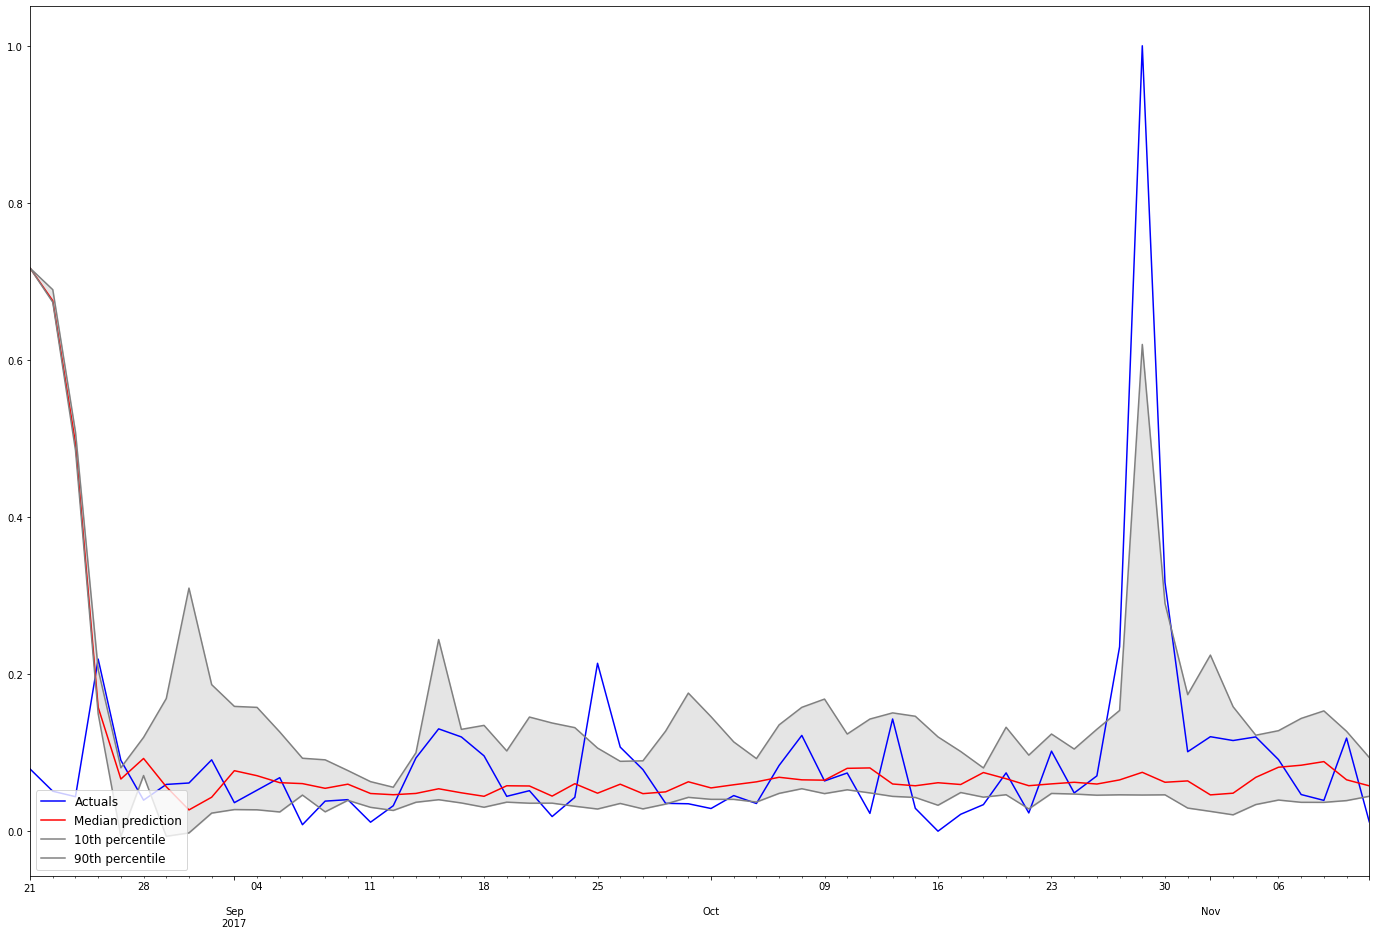

In [89]:
# plot interval with fill
fig, ax_bootstrap = plt.subplots(figsize=(24,16))
bootstrap_predictions_long['actuals'].plot(color = 'blue', label='Actuals', axes=ax_bootstrap)
bootstrap_predictions_long['median'].plot(color = 'red',label = 'Median prediction', axes=ax_bootstrap )
bootstrap_predictions_long['10'].plot(color = 'grey', label = '10th percentile', axes=ax_bootstrap )
bootstrap_predictions_long['90'].plot(color = 'grey', label = '90th percentile', axes=ax_bootstrap )
plt.legend(loc = 'lower left', fontsize = 12)

x = prev_data.index.values[-H:]
plt.fill_between(x, bootstrap_predictions_long['10'], bootstrap_predictions_long['90'], color='grey', alpha=0.2)

The long prediciton horizon graph above shows a similar result to the short horizon prediciton, the actual values appear to sit within the 10th and 90th percentile range for majority of the time. However, the nerual network is unable to predict the large spike that occurs around the 30 October,

# Task 6 - Model Evaluation
Evaluate the forecast performance of your model-based and pure forecasters using the test data and compare the two forecasters. Use appropriate evaluation metrics and methods. Discuss the similarities and difference between their performance and suggest possible avenues for improvement.

Mean absolute error for point forcasting and quantile scores for distributional forcast accuracy

In [90]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_pinball_loss

### Evaluation of Point Forcasting
Evaluation of point forcasting will be done seperate

For the following Mean absolute error comparison we need to scale the arima results down similar to what we have done for the nerual network results.

In [91]:
# Grab y pred and y test for arima model
arima_y_pred = pd.DataFrame(arima_pred['Seasonal'])
arima_y_test = pd.DataFrame(test_amazon)

# Scale the arima pred and test values using MinMaxScaler

arima_y_pred_scaled = scaler.fit_transform(arima_y_pred.values.reshape(-1,1))
arima_y_test_scaled = scaler.fit_transform(arima_y_test.values.reshape(-1,1))

# 60 Day PRediction (Full Horizon)

# Calculate Mean absolute error (MAE)
arima_mae = mean_absolute_error(arima_y_pred_scaled, arima_y_test_scaled)
nn_single_point_mae = mean_absolute_error(y_pred, y_test_scaled)

# Calculate Root Mean Squared Error (RMSE)
arima_rmse = np.sqrt(mean_squared_error(arima_y_pred_scaled, arima_y_test_scaled))
nn_single_point_rmse = np.sqrt(mean_squared_error(y_pred, y_test_scaled))

data = {
    'index': ['MAE', 'RMSE'],
    'ARIMA': [arima_mae, arima_rmse],
    'NN Single Point': [nn_single_point_mae, nn_single_point_rmse]
}

data_df = pd.DataFrame(data)
data_df = data_df.set_index('index')

data_df

,ARIMA,NN Single Point
index,,
MAE,0.507465,0.071354
RMSE,0.590710,0.139648


In [92]:
# 10 Day Predicition
div = 10

# Calculate Mean absolute error (MAE)
arima_mae = mean_absolute_error(arima_y_pred_scaled[:-div], arima_y_test_scaled[:-div])
nn_single_point_mae = mean_absolute_error(y_pred[:-div], y_test_scaled[:-div])
nn_multi_mae = mean_absolute_error(y_pred_multi, y_test_multi)

# Calculate Root Mean Squared Error (RMSE)
arima_rmse = np.sqrt(mean_squared_error(arima_y_pred_scaled[:-div], arima_y_test_scaled[:-div]))
nn_single_point_rmse = np.sqrt(mean_squared_error(y_pred[:-div], y_test_scaled[:-div]))
nn_multi_rmse = np.sqrt(mean_squared_error(y_pred_multi, y_test_multi))

data = {
    'index': ['MAE', 'RMSE'],
    'ARIMA': [arima_mae, arima_rmse],
    'NN Single Point': [nn_single_point_mae, nn_single_point_rmse],
    'NN Multi Point': [nn_multi_mae, nn_multi_rmse]
}

data_df = pd.DataFrame(data)
data_df = data_df.set_index('index')

data_df

,ARIMA,NN Single Point,NN Multi Point
index,,,
MAE,0.506547,0.060514,0.161979
RMSE,0.593117,0.131260,0.255123


Point forcasting results are shown for both ARIMA and Neural Network models at both long (first table) and short (second table) prediction horizons. When considering long prediction horizons the results show Neural Network is significantly more accurate (MAE=0.065525, RMSE=0.128828) than the ARIMA model (MAE=0.507465, RMSE=0.590710) for both point forcasting accuracy methods (MAE and RMSE).

Similarly when considering the short prediciton horizon the Neural Network is shown to be significantly more accurate than the ARIMA model with much lower values. Additionally, the Single Point NN and Multi Point NN forcasting appears to produce a similar MAE and RMSE values.

Interestingly the ARIMA model apppears to produce very similar MAE and RMSE values when looking at both the long and short prediction horizons.

### Interval Forcast Evaluation

In [93]:
# https://www.lokad.com/pinball-loss-function-definition
results = {}
for alpha in [0.05, 0.5, 0.95]:
    metrics = {}
    metrics["ARIMA"] = mean_pinball_loss(arima_y_test_scaled, arima_y_pred_scaled, alpha=alpha)
    metrics["Neural Net"] = mean_pinball_loss(y_test_multi, y_pred_multi, alpha=alpha)
    results[alpha] = metrics

pd.DataFrame(results)

,0.05,0.50,0.95
ARIMA,0.459565,0.253733,0.047900
Neural Net,0.138393,0.080990,0.023586


For mean pinball loss a lower value indicates a more accurate quantile forcast.

The results show that the neural network has a more accurate quantile forcast for each value of alpha.

At an alpha of 0.05 the Neural Net results in a mean pinball loss of 0.053 which is significantly smaller than the mean pinball loss for ARIMA model of 0.4595 indicating a much more accurate model at alpha 0.05. Looking at alpha 0.95 the difference between the model results is much smaller with Neural Network at 0.0158 and ARIMA at 0.0479.

The two forcasting methods explored above both result in a more accurate score for the Neural Network. Both models show a similar horizontal trend, the main difference is how the seasonality is represented between ARIMA and Neural Network, where ARIMA has a tiled seasonal component the neural network is capable of more adaptable seasonality.

Possible Improvements
- More computational power to have the ability to create a larger deep neural network
- Include more time steps and exogenous variables into the neural network input layer